# Прогнозирование стоимости жилья для агентства недвижимости

In [1]:
#импорт библиотек
import warnings
warnings.filterwarnings("ignore") # отключаем предупреждения

import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import squarify # для упрощения создания диаграммы treemap

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
import category_encoders as ce # для работы с кодировщиком
%matplotlib inline
plt.style.use('seaborn')

In [2]:
#читаем выданные данные
data = pd.read_csv('data.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Описание данных:

* 'status' — статус продажи;
* 'private pool' и 'PrivatePool' — наличие собственного бассейна;
* 'propertyType' — тип объекта недвижимости;
* 'street' — адрес объекта;
* 'baths' — количество ванных комнат;
* 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
* 'fireplace' — наличие камина;
* 'city' — город;
* 'schools' — сведения о школах в районе;
* 'sqft' — площадь в футах;
* 'zipcode' — почтовый индекс;
* 'beds' — количество спален;
* 'state' — штат;
* 'stories' — количество этажей;
* 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
* 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

## Разведывательный анализ

### Обработка целевого признака $'target'$

In [3]:
data['target'] = data['target'].apply(lambda x: '1326000' if x == '$1,215 - $1,437/mo' else x) # для значения $1,215 - $1,437/mo
data['target'] = data['target'].apply(lambda x: str(x).replace('/mo','000')) # добавим один разряд
data['target'] = data['target'].apply(lambda x: str(x).replace('$','')) # удалим лишние символы
data['target'] = data['target'].apply(lambda x: str(x).replace('+','')) # удалим лишние символы
data['target'] = data['target'].apply(lambda x: str(x).replace(',','')) # удалим лишние символы
data['target'] = data['target'].apply(lambda x: np.nan if x == 'nan' else float(x)) # переведем пропуски в np.nan и пока сохраним их

In [4]:
# посмотрим на показатели
data['target'].describe()

count    3.747040e+05
mean     6.481469e+05
std      1.850090e+06
min      1.000000e+00
25%      1.880000e+05
50%      3.209000e+05
75%      5.850000e+05
max      1.950000e+08
Name: target, dtype: float64

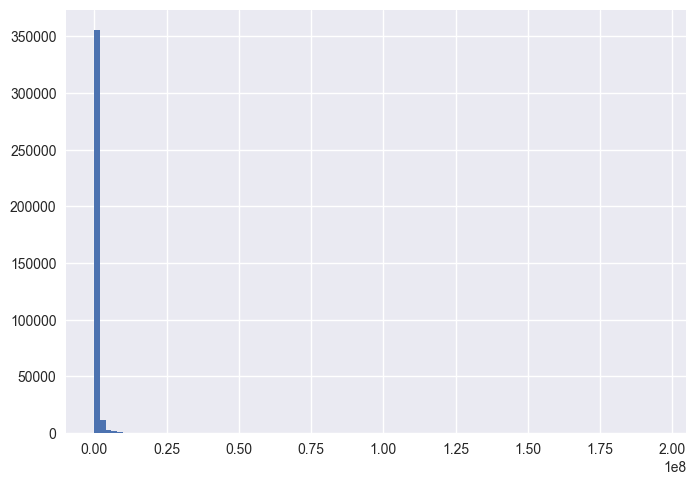

In [5]:
# посмотрим на распределение
data['target'].hist(bins=100);

In [6]:
# посмотрим на объекты дороже 10 млрд долларов
data[data['target'] > 1e+07]

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
221,for sale,NaN,coop,895 Park Ave #6/7A,8 Baths,"{'atAGlanceFacts': [{'factValue': '1930', 'fac...",NaN,New York,"[{'rating': ['9/10', '8/10', '3/10', '8/10', '...",NaN,10075,6 Beds,NY,NaN,NaN,NaN,00112959,15000000.0
437,for sale,NaN,single-family home,2665 Castilla Isle,9 Baths,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",yes,Fort Lauderdale,"[{'rating': ['7/10', '5/10', '7/10'], 'data': ...","10,330 sqft",33301,7 Beds,FL,3.0,NaN,yes,F10158668,24000000.0
609,for rent,NaN,multi-family,220 Boylston St #1412,2 Baths,"{'atAGlanceFacts': [{'factValue': '1985', 'fac...",yes,Boston,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,673 sqft",2116,2 Beds,MA,NaN,NaN,NaN,72580936,10500000.0
668,for sale,NaN,condo,451 E Grand Ave #65,6 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '4/10', '7/10'], 'data': ...","7,587 sqft",60611,4 Beds,IL,9.0,NaN,yes,10470503,15174000.0
1198,NaN,NaN,Condo,1000 Biscayne Blvd UNIT 1002,7.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...","8,360",33132,5,FL,NaN,NaN,Yes,A10678530,12250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376141,for sale,NaN,condo,62 Wooster St #5,5 Baths,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,New York,"[{'rating': ['9/10', '8/10', '3/10', '8/10', '...","5,874 sqft",10012,4 Beds,NY,6.0,NaN,NaN,2172102,14995000.0
376425,For sale,NaN,Townhouse,46 E 65th St,10,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,New York,"[{'rating': ['10/10', '3/10', '8/10'], 'data':...","13,487",10065,7,NY,NaN,NaN,NaN,NaN,13400000.0
376459,Active,NaN,NaN,MLS #: DEGI4021965,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,New York,"[{'rating': ['7', '9', '8', '8', '8'], 'data':...",NaN,10011,Bath,NY,NaN,NaN,NaN,DEGI4021965,15000000.0
376749,for sale,NaN,townhouse,26 E 73rd St,8 Baths,"{'atAGlanceFacts': [{'factValue': '1899', 'fac...",NaN,New York,"[{'rating': ['9/10', '8/10', '3/10', '8/10', '...","7,500 sqft",10021,5 Beds,NY,5.0,NaN,NaN,00113946,25000000.0


Может и выбросы или ошибка в разрадяности, но удалять рука не поднимается

### Обработка признака $'status'$

In [7]:
data.status = data.status.apply(lambda x: str(x)) # переводим все значения в строковые
data.status = data.status.apply(lambda x: x.lower()) # переводим всё в нижний регистр
data.status = data.status.apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы

In [8]:
data.status.value_counts().head(10)

for sale                     199571
active                       105207
nan                           39918
foreclosure                    6769
new construction               5475
pending                        4807
pre-foreclosure                2119
pre-foreclosure / auction      1560
p                              1488
under contract show            1183
Name: status, dtype: int64

In [9]:
# создаем списки разных типов с учетом информации из Брифа
foreclosure=[]
pre_foreclosure=[]
contract=[]
backup=[]
pending=[]
inspection=[]
auction=[]
sale=[]
rent=[]

# наполняем списки различными вариантами указания типов статуса
for status in data.status.unique():
    if (status == 'foreclosed') or (status == 'contingent foreclosure'):
        foreclosure.append(status)
    if (status == 'pre-foreclosure') or (status == 'pre-foreclosure / auction') or (status == 'pf'):
        pre_foreclosure.append(status)
    if (('contract' in status) or ('offer' in status) or (status == 'c') or (status == 'ct') or (status == 'c continue show')) and ('backup' not in status):
        contract.append(status)
    if ('backup' in status) and ('pending' not in status):
        backup.append(status)
    if (('conting' in status) or ('pending' in status) or (status == 'p') or (status == 'ps') or (status == 'uc continue to show')) and ('inspect' not in status):
        pending.append(status)
    if ('insp' in status) or ('diligence' in status) or (status == 'pi'):
        inspection.append(status)
    if ('auction' in status):
        auction.append(status)
    if ('activ' in status) or ('sale' in status) or ('soon' in status) or ('purchase' in status) or ('new' in status) or \
        (status == 'price change') or (status == 'back on market') or (status == 'listing extended'):
        sale.append(status)
    if ('rent' in status):
        rent.append(status)

In [10]:
# статус «лишён права выкупа»
data.status = data.status.apply(lambda x: 'foreclosure' if x in foreclosure else x)

# статус «до выкупа», «аукцион до выкупа» объединим с продажей с помощью аукциона
data.status = data.status.apply(lambda x: 'auction' if (x in pre_foreclosure) or (x in auction) else x)

# ситуации, когда предложение сделано или договор заключен или ожидается инспекция, объединим в одну группу, т.к. продавец продолжает показы
data.status = data.status.apply(lambda x: 'backup' if (x in contract) or (x in backup) or (x in pending) or (x in inspection) else x)

# продажа
data.status = data.status.apply(lambda x: 'sale' if x in sale else x)

# аренда
data.status = data.status.apply(lambda x: 'rent' if x in rent else x)

# нет информации
data.status = data.status.apply(lambda x: 'no info' if x == 'nan' else x)

In [11]:
# анализируем остатки
for status in data.status.unique():
    print(status)

sale
no info
backup
auction
foreclosure
rent
recently sold
closed
sold: $285,000
sold: $15,000


In [12]:
# в ходе анализа нашли интересные кейсы: объект продан, цена в 'target' не указана, зато указана в статусе, перенесем ее в 'target'
data.loc[data[data['status'] == 'sold: $15,000'].index[0], 'target'] = 15000
data.loc[data[data['status'] == 'sold: $285,000'].index[0], 'target'] = 285000
data.status = data.status.apply(lambda x: 'sold' if ('sold' in x) or (x == 'closed') else x)

In [13]:
# анализируем итог
data.status.value_counts()

sale           312211
no info         39918
backup          11914
foreclosure      7230
auction          5193
rent              412
sold              307
Name: status, dtype: int64

In [14]:
# проверим соотношение цен на продажу и аренду
print(data[data.status == 'rent']['target'].median())
print(data[data.status == 'sale']['target'].median())

2100000.0
327000.0


Аренда дороже продажи - это как? Удалим, чтобы не мешало.

In [15]:
data = data[data.status != 'rent']
data.reset_index(drop=True, inplace=True)

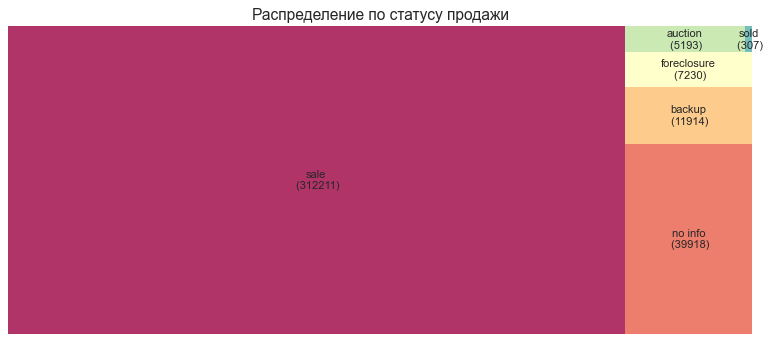

In [16]:
# функция создания диаграммы treemap
def creat_treemap(
    df,                  # датафрейм
    col,                 # признаки
    title,               # заголовок
    title_fontsize=14,   # размер шрифта в заголовке
    size=[8, 4]):        # размер фигуры

    grouped = df.groupby(col).size().sort_values(ascending=False).reset_index(name='Counts')
    labels = grouped.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
    sizes = grouped['Counts'].values.tolist()
    colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

    plt.figure(figsize=(size[0], size[1]), dpi= 80)
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

    plt.title(title, size=title_fontsize)
    plt.axis('off')
    plt.show();

creat_treemap(data, 'status', 'Распределение по статусу продажи', size=[12, 5])

Цена аренды на порядок ниже, что ожидаемо. Запоминм этот факт и после обработки остальных признаков "отселим" данные в отдельный датафрейм

### Обработка признаков $'private pool'$ и $'PrivatePool'$

In [17]:
# посмотрим на уникальные значения
print(data['private pool'].unique())
print(data['PrivatePool'].unique())

[nan 'Yes']
[nan 'yes' 'Yes']


In [18]:
# приведем к единообразию
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: 'Yes' if x is not np.nan else x)

In [19]:
# объединим столбцы и закодируем
data['PrivatePool'] = data['PrivatePool'].fillna(data['private pool'])
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: 1 if x is not np.nan else 0)

# удалим лишний столбец
data = data.drop('private pool', axis=1)

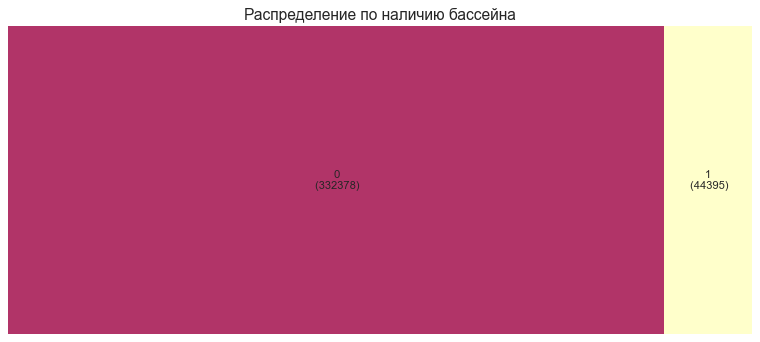

In [20]:
creat_treemap(data, 'PrivatePool', 'Распределение по наличию бассейна', size=[12, 5])

### Обработка признака $'propertyType'$

In [21]:
data.propertyType = data.propertyType.apply(lambda x: str(x)) # переводим все значения в строковые
data.propertyType = data.propertyType.apply(lambda x: x.lower()) # переводим всё в нижний регистр
data.propertyType = data.propertyType.apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы

In [22]:
data.propertyType.value_counts(dropna=False).head(30)

single-family home               91989
single family                    62869
condo                            42522
nan                              34733
single family home               31728
lot/land                         20552
townhouse                        18353
land                             10934
multi-family                      7789
condo/townhome/row home/co-op     7701
traditional                       5913
coop                              3266
multi family                      2792
high rise                         1823
ranch                             1781
mobile/manufactured               1618
detached, one story               1614
single detached, traditional      1581
contemporary                      1557
multi-family home                 1501
1 story                           1235
colonial                          1205
mobile / manufactured             1066
contemporary/modern               1000
apartment                          915
2 stories                

In [23]:
# создаем списки разных типов с учетом информации из Брифа
apartment=[]
condo=[]
small_house=[]
townhouse=[]
cottage=[]
farmhouse=[]
log_house=[]
land=[]
other_property=[]

# наполняем списки различными вариантами указания типов статуса
for property in data.propertyType.unique():
    if ('apartment' in property):
        apartment.append(property)
    elif ('condo' in property) or ('coop' in property):
        condo.append(property)
    elif ('single' in property) or ('detach' in property) or ('tiny' in property):
        small_house.append(property)
    elif ('town' in property):
        townhouse.append(property)
    elif ('cottage' in property):
        cottage.append(property)
    elif ('farm' in property):
        farmhouse.append(property)
    elif ('log' in property) or ('bungal' in property) or ('garden' in property):
        log_house.append(property)
    elif ('land' in property):
        land.append(property)
    else:
        other_property.append(property)

In [24]:
# съёмная квартира (нельзя купить)
data.propertyType = data.propertyType.apply(lambda x: 'apartment' if x in apartment else x)

# кондоминиум
data.propertyType = data.propertyType.apply(lambda x: 'condo' if x in condo else x)

# отдельный маленький дом
data.propertyType = data.propertyType.apply(lambda x: 'small_house' if x in small_house else x)

# таунхаус
data.propertyType = data.propertyType.apply(lambda x: 'townhouse' if x in townhouse else x)

# небольшая уютная веранда, небольшие жилые помещения
data.propertyType = data.propertyType.apply(lambda x: 'cottage' if x in cottage else x)

# прямоугольная планировка, большое крыльцо, амбарная крыша
data.propertyType = data.propertyType.apply(lambda x: 'farmhouse' if x in farmhouse else x)

# деревянный дом
data.propertyType = data.propertyType.apply(lambda x: 'log_house' if x in log_house else x)

# земля
data.propertyType = data.propertyType.apply(lambda x: 'land' if x in land else x)

# другие
data.propertyType = data.propertyType.apply(lambda x: 'other' if (x in other_property) and (x is not np.nan) else x)

In [25]:
# анализируем итог
data.propertyType.value_counts(dropna=False).head(30)

small_house    192645
other           76328
condo           55270
land            31494
townhouse       18537
log_house         992
apartment         939
farmhouse         486
cottage            82
Name: propertyType, dtype: int64

Согласно описанию, апартаменты нельзя продать, это съемная квартира. Удалим, чтобы не смущало.

In [26]:
data = data[data.propertyType != 'apartment']
data.reset_index(drop=True, inplace=True)

Также по условиям задачи мы должны предсказывать стоиомсть жилья, а в датасете есть земля. Удалим ее полностью, хоть и жалко столько строчек

In [27]:
data = data[data.propertyType != 'land']
data.reset_index(drop=True, inplace=True)

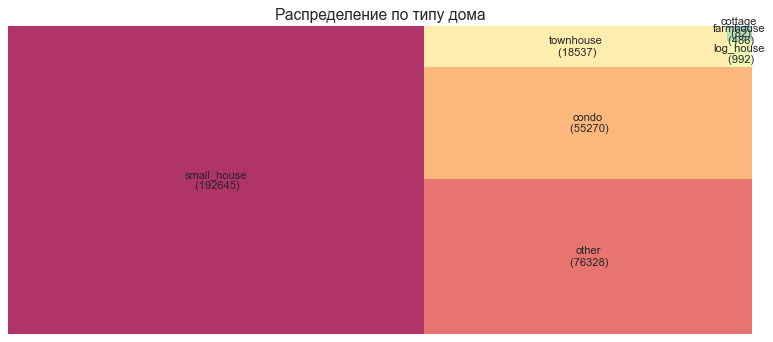

In [28]:
creat_treemap(data, 'propertyType', 'Распределение по типу дома', size=[12, 5])

### Обработка адреса: признаков $'zipcode'$ — почтовый индекс, $'state'$ — штат, $'city'$ — город, $'street'$ — адрес объекта

Найти и подключить по API данные обо всех городах США мне не удалось. Поэтому будем использовать только данные с [википедии](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A1%D0%A8%D0%90_%D1%81_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC_%D0%B1%D0%BE%D0%BB%D0%B5%D0%B5_100_%D1%82%D1%8B%D1%81%D1%8F%D1%87_%D0%B6%D0%B8%D1%82%D0%B5%D0%BB%D0%B5%D0%B9) о населении городов США свыше 100тыс. жителей.

In [29]:
# подгружаем подготовленные данные о населении
cities_population = pd.read_excel('cities.xlsm')
cities_population.head()

,city,population
0,New York,8467513
1,Los Angeles,3849297
2,Chicago,2696555
3,Houston,2288250
4,Phoenix,1624569


In [30]:
# присоединяем подготовленные данные о населении
data = data.merge(cities_population, how='left', on='city')

In [31]:
data.street = data.street.apply(lambda x: str(x)) # переводим все значения в строковые
data.street = data.street.apply(lambda x: x.lower()) # переводим всё в нижний регистр
data.street = data.street.apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы

In [32]:
# посмотрим внимательнее на адреса (улица и номер дома)
data.street.value_counts(dropna=False).head(30)

address not disclosed          632
undisclosed address            520
(undisclosed address)          390
address not available          129
unknown address                 72
2103 e state hwy 21             57
11305 gulf fwy                  54
8426 terrace valley circle      50
17030 youngblood rd.            38
1727 opal field lane            34
3435 heather garden trail       34
24423 ferdossa drive            34
3423 heather garden trail       34
606 vineyard hollow court       32
9470 lancaster rd. sw           32
9915 camellia gardens drive     30
9522 summer river dr            28
2914 karlissa trail             28
18122 shimmer lane              28
24807 twilight hollow lane      28
1 palmer dr                     27
9845 basil western rd nw        25
6320 sw 89th court road         24
8447 sw 99th street rd          22
24811 twilight hollow ln.       20
5221 s. zapata hwy              20
8314 magnolia bay ct.           20
614 vineyard hollow ct          20
25115 easton ramsey 

In [33]:
# приведем к единообразию отсутствие адресов
def unknown_address(street):
    if ('disclos' in street) or ('availab' in street) or ('unkn' in street): 
        street = 'unknown'
    return street

data['street'] = data['street'].apply(lambda x: unknown_address(x))

In [34]:
# оставим только обозначения типа улицы
data['street_type'] = data['street'].apply(lambda x: str(x).split()[-1])

In [35]:
data.head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,population,street_type
0,sale,small_house,240 heather ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,0,611019,418000.0,NaN,ln
1,sale,small_house,12911 e heroy ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,0,201916904,310000.0,105905.0,ave
2,sale,small_house,2005 westridge rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,1,FR19221027,2895000.0,3849297.0,rd
3,sale,small_house,4311 livingston ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,0,14191809,2395000.0,1288457.0,ave
4,sale,townhouse,1624 s newkirk st,NaN,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897 sqft,19145,2 Beds,PA,2.0,NaN,0,PAPH847006,209000.0,1576251.0,st


In [36]:
# посмотрим внимательнее на последнее слово в обозначении улицы
data.street_type.value_counts(dropna=False).head(30)

st         52986
dr         46042
ave        37040
rd         20339
ln         18237
ct         13926
way         6858
pl          6619
cir         5835
blvd        5553
ter         3904
ne          3167
s           2616
trl         2540
n           2477
nw          2440
se          2066
sw          1821
unknown     1749
e           1444
#1          1075
loop        1004
w            957
#2           899
cv           894
b            779
drive        756
a            754
pkwy         718
park         709
Name: street_type, dtype: int64

In [37]:
# заменяем обозначение улицы
def get_street_type(s):
    if s == 'st' or s == 'street':
        return 'street'
    elif s == 'ave' or s == 'avenue':
        return 'avenue'
    elif s == 'rd' or s == 'road':
        return 'road'
    elif s == 'lane' or s == 'ln':
        return 'lane'
    elif s == 'dr' or s == 'drive':
        return 'drive'
    elif s == 'blvd' or s == 'boulevard':
        return 'boulevard'
    elif s == 'trail' or s == 'trl' or s == 'tr':
        return 'trail'
    elif s == 'way' or s == 'hwy':
        return 'way'
    elif s == 'cir' or s == 'circle':
        return 'circle'
    elif s == 'ct' or s == 'court':
        return 'court'
    elif s == 'pl' or s == 'place':
        return 'place'
    else:
        return 'Other'

data.street_type = data.street_type.apply(lambda x: get_street_type(x))

In [38]:
# проверяем результат
data.street_type.unique()

array(['lane', 'avenue', 'road', 'street', 'court', 'drive', 'Other',
       'circle', 'place', 'boulevard', 'way', 'trail'], dtype=object)

In [39]:
# удаляем лишние столбцы
data = data.drop(['street', 'zipcode', 'state'], axis=1)

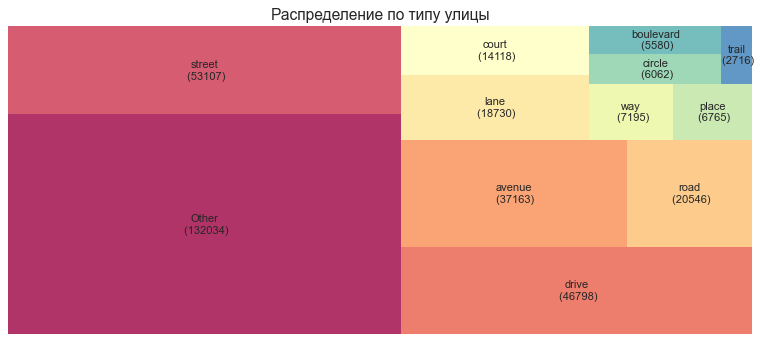

In [40]:
creat_treemap(data, 'street_type', 'Распределение по типу улицы', size=[12, 5])

In [41]:
data.population = data.population.fillna(0)

In [42]:
# переводим города в категории, исходя из населения
def get_city_population(pop):
    if pop == 0:
        city = 'other'
    if 0 < pop <= 150000:
        city = 'low'
    if 150000 < pop <= 400000:
        city = 'low_middle'
    if 400000 < pop <= 800000:
        city = 'upper_middle'
    if 800000 < pop <= 1000000:
        city = 'high'
    if pop > 1000000:
        city = 'million'
    return city

data.city = data.population.apply(lambda x: get_city_population(x))

In [43]:
# удалим лишний столбец
data = data.drop('population', axis=1)

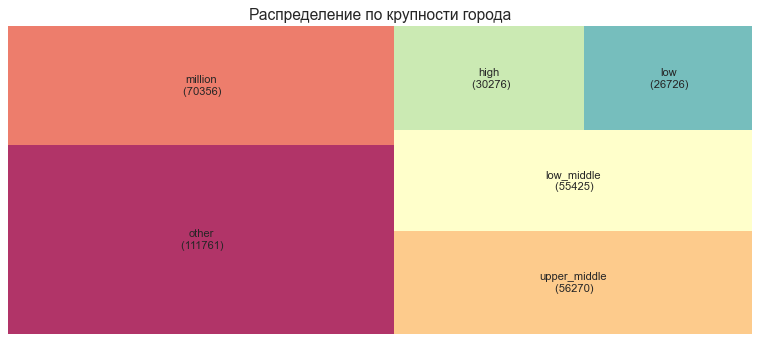

In [44]:
creat_treemap(data, 'city', 'Распределение по крупности города', size=[12, 5])

### Обработка признака $'baths'$

In [45]:
data.baths = data.baths.apply(lambda x: str(x)) # переводим все значения в строковые
data.baths = data.baths.apply(lambda x: x.lower()) # переводим всё в нижний регистр
data.baths = data.baths.apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы

In [46]:
data.baths.unique()

array(['3.5', '3 baths', '2 baths', '8 baths', 'nan', '2', '3',
       'bathrooms: 2', '1,750', '4 baths', '2 ba', 'bathrooms: 5',
       '1,000', '7 baths', '2.0', '3.0', 'bathrooms: 1', '4.0',
       '2.1 baths', '2.5 baths', '1', 'bathrooms: 3', '4.5', '6 baths',
       'bathrooms: 4', '3 ba', '5', '2,500', '5.5 baths', '1.0',
       '5 baths', '1.5', '4', '~', '2.5', '4,000', '3.5 baths', '2,000',
       '3,000', '8.0', '1 ba', '3.5 ba', '5.0', '1,500', '7.0', '1,250',
       '9 baths', '2,250', '6.0', '12 baths', '5.5', '3,500', '1.5 baths',
       '2,750', 'bathrooms: 6', '4.5 baths', '0', '750', '5.5+', '6',
       '10 baths', '6 ba', 'bathrooms: 19', '10.0', '1.5 ba', '4 ba',
       '12 ba', '2.5+', '8', '7.5+', 'bathrooms: 10', '0 / 0', 'sq. ft.',
       '5 ba', '4.5+', '18 baths', '-- baths', 'bathrooms: 7', '7', '18',
       '3.5+', '1.5+', '11 baths', '5,000', '1.75 baths', '9', '12.0',
       '1.1 baths', '6.5', 'bathrooms: 8', '10', '19 baths',
       'bathrooms: 9', '16 

In [47]:
# избавимся от лишних символов и преобразуем уникальные значения
data['baths'] = data['baths'].apply(lambda x: str(x).replace('baths','').replace('bathrooms','').replace('ba',''))
data['baths'] = data['baths'].apply(lambda x: str(x).replace(',','.'))
data['baths'] = data['baths'].apply(lambda x: str(x).replace(' ',''))
data['baths'] = data['baths'].apply(lambda x: str(x).replace(':',''))
data['baths'] = data['baths'].apply(lambda x: str(x).replace('',''))
data['baths'] = data['baths'].apply(lambda x: np.nan if (str(x) == '~') or (str(x) == 'sq.ft.') or (str(x) == '--') or (str(x) == '—') else x)
data['baths'] = data['baths'].apply(lambda x: str(x).replace('+',''))
data['baths'] = data['baths'].apply(lambda x: str(x).replace('1-0/1-0/1','3'))
data['baths'] = data['baths'].apply(lambda x: str(x).replace('116/116/116','3'))
data['baths'] = data['baths'].apply(lambda x: str(x).replace('semimod','1'))
data['baths'] = data['baths'].apply(lambda x: str(x).replace('3-1/2-2','5'))
data['baths'] = data['baths'].apply(lambda x: str(x).replace('1/1/1/1','4'))
data['baths'] = data['baths'].apply(lambda x: str(x).replace('2-1/2-1/1-1/1-1','4'))
data['baths'] = data['baths'].apply(lambda x: str(x).replace('1/1-0/1-0/1-0','2'))
data['baths'] = data['baths'].apply(lambda x: str(x).replace('1-2','2'))
data['baths'] = data['baths'].apply(lambda x: str(x).replace('1/3-0','2'))
data['baths'] = data['baths'].apply(lambda x: str(x).replace('0/0','0'))

In [48]:
# переведем в числовой формат
data['baths'] = data['baths'].apply(lambda x: round(float(x), 0) if x is not np.nan else x)

In [49]:
# изучим распределение
data.baths.value_counts(dropna=False)

2.0      126945
NaN       80965
3.0       68702
4.0       34724
1.0       19532
5.0        9517
6.0        5048
7.0        2077
8.0        1280
9.0         543
10.0        351
750.0       237
0.0         207
11.0        190
12.0        142
13.0         73
16.0         54
14.0         48
18.0         32
15.0         28
24.0         18
20.0         16
17.0         10
22.0         10
26.0          8
23.0          8
30.0          6
27.0          5
40.0          4
21.0          4
36.0          3
32.0          3
19.0          3
44.0          3
34.0          2
28.0          2
29.0          2
39.0          1
64.0          1
42.0          1
60.0          1
241.0         1
43.0          1
41.0          1
25.0          1
55.0          1
76.0          1
35.0          1
68.0          1
Name: baths, dtype: int64

In [50]:
data['baths'] = data['baths'].fillna(2) # заполним пропусти модальным значением
data['baths'] = data['baths'].apply(lambda x: '>4' if x > 4 else str(x)) # ограничим максимальное число и переведе обратно в строковый вид

In [51]:
# посмотрим на итог
data.baths.value_counts(dropna=False)

2.0    207910
3.0     68702
4.0     34724
>4      19739
1.0     19532
0.0       207
Name: baths, dtype: int64

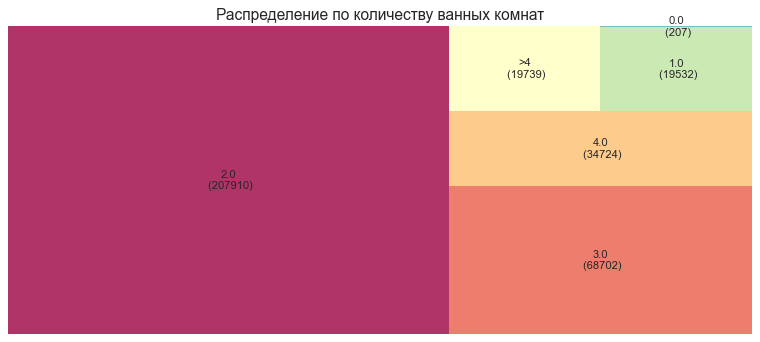

In [52]:
creat_treemap(data, 'baths', 'Распределение по количеству ванных комнат', size=[12, 5])

### Обработка признака $'homeFacts'$

In [53]:
# посмотрим на одну ячейку
data.homeFacts.iloc[0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

In [54]:
facts = eval(data.homeFacts.iloc[0]) # eval исполняет строку, в нашем случае создает словарь
facts

{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'},
  {'factValue': '', 'factLabel': 'Remodeled year'},
  {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'},
  {'factValue': '', 'factLabel': 'Cooling'},
  {'factValue': '', 'factLabel': 'Parking'},
  {'factValue': None, 'factLabel': 'lotsize'},
  {'factValue': '$144', 'factLabel': 'Price/sqft'}]}

In [55]:
# создаем переменные
d = dict()
year_built = list()
remodeled_year = list()
geating = list()
cooling = list()
parking = list()
lotsize = list()
price_sqft = list()

# проходим по всем строкам датафрейма
for row in range(data.homeFacts.shape[0]):
    facts = eval(data.homeFacts[row]) # eval исполняет строку, в нашем случае создает словарь
    
    # вынимаем данные в списки
    year_built.append(facts['atAGlanceFacts'][0]['factValue'])
    remodeled_year.append(facts['atAGlanceFacts'][1]['factValue'])
    geating.append(facts['atAGlanceFacts'][2]['factValue'])
    cooling.append(facts['atAGlanceFacts'][3]['factValue'])
    parking.append(facts['atAGlanceFacts'][4]['factValue'])
    lotsize.append(facts['atAGlanceFacts'][5]['factValue'])
    price_sqft.append(facts['atAGlanceFacts'][6]['factValue'])

# заполняем словарь
d['Year built'] = year_built
d['Remodeled year'] = remodeled_year
d['Heating'] = geating
d['Cooling'] = cooling
d['Parking'] = parking
d['lotsize'] = lotsize
d['Price/sqft'] = price_sqft

# создаем датафрейм
df_homeFacts = pd.DataFrame(d)
df_homeFacts.head()

,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,2019,,"Central A/C, Heat Pump",,,None,$144
1,2019,,,,,5828 sqft,$159/sqft
2,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft
3,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft
4,1920,,Forced Air,Central,,680 sqft,$233/sqft


In [56]:
# объединим таблицы с удалением старого столбца
data = pd.concat([data.drop('homeFacts', axis=1), df_homeFacts], axis=1)

### Обработка признака $'schools'$

In [57]:
# посмотрим на одну ячейку
data.schools.iloc[0]

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

In [58]:
# структурируем вывод
school = eval(data.schools[0]) # eval исполняет строку, в нашем случае создает словарь
school

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'],
  'data': {'Distance': ['2.7 mi',
    '3.6 mi',
    '5.1 mi',
    '4.0 mi',
    '10.5 mi',
    '12.6 mi',
    '2.7 mi',
    '3.1 mi'],
   'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']},
  'name': ['Southern Pines Elementary School',
   'Southern Middle School',
   'Pinecrest High School',
   'Southern Pines Primary School',
   "Crain's Creek Middle School",
   'Union Pines High School',
   'Episcopal Day Private School',
   'Calvary Christian Private School']}]

In [59]:
# функция получения параметров описания ближайших школ
def get_school_pars(row): # row = data.schools.iloc[0]
    
    school = eval(row) # eval исполняет строку, в нашем случае создает словарь
    
    # достанем средний рейтинг школ
    rate = school[0]['rating'] # обозначим переменную за элемент списка
    n = len(rate) # обозначим переменную длины списка
    fillna_rate = [] # подготовим пустой список для сохранения рейтингов
    # достанем все имеющиеся рейтинги
    for i in range(n):
        rate[i] = str(rate[i]).replace('/10','')
        if rate[i].isdigit() != False:
            fillna_rate.append(float(rate[i]))
    # рассчитаем средний рейтинг     
    mean_rate = np.mean(fillna_rate)

    # достанем медианную дальность школ
    dist = school[0]['data']['Distance'] # обозначим переменную за элемент списка
    n = len(dist) # обозначим переменную длины списка
    list_dist = [] # подготовим пустой список для сохранения дальностей
    # достанем все имеющиеся дальности
    for i in range(n):
        dist[i] = str(dist[i]).replace(' ','')
        dist[i] = str(dist[i]).replace('mi','')
        if isinstance(float(dist[i]), (int, float)):
            list_dist.append(float(dist[i]))
    # рассчитаем медианную дальность
    median_dist = np.median(list_dist)

    # определим покрытие ближайших школ необходимого уровня образования
    education = school[0]['data']['Grades'] # обозначим переменную за элемент списка
    # исчерпывающее множество уровней образования США (https://www.unipage.net/ru/schools_usa)
    all_education = {'Nursery School', 'Kindergarten', 'Elementary School', 'Middle School', 'High School'}
    current_education = set() # подготовим пустое множество для сохранения уровня образования
    n = len(education) # обозначим переменную длины списка

    # заполним множество различных уровней образования, которое предлагается в ближайших школах
    for i in range(n):
        if education[i] == np.nan:
            current_education.add('None')
        else:
            if education[i] is None:
                current_education.add('5')
                break
            if 'P' in education[i]:
                current_education.add('Nursery School')
            if 'K' in education[i]:
                current_education.add('Kindergarten')
            if ('1' in education[i]) or ('2' in education[i]) or ('3' in education[i]) or ('4' in education[i]) or ('5' in education[i]):
                current_education.add('Elementary School')
            if ('6' in education[i]) or ('7' in education[i]) or ('8' in education[i]):
                current_education.add('Middle School')
            if ('9' in education[i]) or ('10' in education[i]) or ('11' in education[i]) or ('12' in education[i]):
                current_education.add('High School')

    # рассчитаем разность предлагаемого уровня образования с исчерпывающим списком
    if current_education == ['5']:
        total_education = '5'
    elif (len(all_education - current_education) == 0) and (len(current_education - all_education) == 0):
        total_education = 'all'
    elif len(all_education - current_education) == 5:
        total_education = np.nan
    elif len(all_education - current_education) > 0:
        total_education = str((-1)*len(all_education - current_education))
    elif len(current_education - all_education) > 0:
        total_education = str(len(current_education - all_education))

    # возвращаем список с результатами извлечения признаков школ: 
    # - средний рейтинг, 
    # - медианная дальность,
    # - полнота предлагаемого уровня образования.
    return [n, mean_rate, median_dist, total_education] 

In [60]:
# запуск функции извлечения признаков школ
school_list = data.schools.apply(get_school_pars)

In [61]:
# преобразуем результаты в датафрейм
df_schools = pd.DataFrame(school_list.to_list(), columns=['schools_count', 'schools_mean_rate', 'schools_median_dist', 'schools_allow_education'])

In [62]:
# объединим таблицы с удалением старого столбца
data = pd.concat([data.drop('schools', axis=1), df_schools], axis=1)

In [63]:
data.head()

,status,propertyType,baths,fireplace,city,sqft,beds,stories,mls-id,PrivatePool,...,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,schools_count,schools_mean_rate,schools_median_dist,schools_allow_education
0,sale,small_house,4.0,Gas Logs,other,2900,4,NaN,NaN,0,...,,"Central A/C, Heat Pump",,,None,$144,8,5.200000,3.80,all
1,sale,small_house,3.0,NaN,low,"1,947 sqft",3 Beds,2.0,NaN,0,...,,,,,5828 sqft,$159/sqft,3,4.000000,1.32,all
2,sale,small_house,2.0,yes,million,"3,000 sqft",3 Beds,1.0,NaN,1,...,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,3,6.666667,2.06,-1
3,sale,small_house,>4,yes,million,"6,457 sqft",5 Beds,3.0,NaN,0,...,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,4,9.250000,0.93,all
4,sale,townhouse,2.0,NaN,million,897 sqft,2 Beds,2.0,NaN,0,...,,Forced Air,Central,,680 sqft,$233/sqft,0,NaN,NaN,NaN


### Обработка признака $'fireplace'$

In [64]:
data.fireplace = data.fireplace.apply(lambda x: str(x)) # переводим все значения в строковые
data.fireplace = data.fireplace.apply(lambda x: x.lower()) # переводим всё в нижний регистр
data.fireplace = data.fireplace.apply(lambda x: str(x).replace(',',' ')) # удаляем запятые
data.fireplace = data.fireplace.apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы

In [65]:
# меняем на числа ошибочные символы
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('!','1'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('@','2'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('#','3'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('$','4'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('%','5'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('^','6'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('&','7'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('*','8'))

In [66]:
def get_fireplace(row):
    
    # список возможного количества каминов
    nums = ['1','2','3','4','5','6','7','8','9','0','one','two','three','four','five','six','seven','eight','nine']
    # список распространенных слов из описаний каминов
    options = ['location','gas','log','logs','wood','burning','features','great','special','ceiling','fan','extra',
               'closets','walk-in','fuel','den','/','utility','connection','storage','starter','vented', 'room',
               'in','firepit','fireplace','air','filter','electric','fire','pit','fp', 'livg','familyrm','family']
    # список вариантов отсутствия камина
    no_fireplace = ['no','not','non','decorative']
    
    # найдем значения, указывающие на отсутствие камина
    split_str = row.split(' ')
    for no in no_fireplace:
        if no in split_str:
            return 'no info'
    
    # если указано количество каминов, сразу вернем его
    for num in nums:
        if num in row:
            return num
    
    # если камин описан, считаем, что он есть
    for option in options:
        if option in row:
            return '1'
    
    # обработаем возвращение стандартных значений
    if (row is np.nan) or (row == 'nan'):
        return 'no info' # сразу избавляемся от пропусков
    elif row == 'yes':
        return 'yes'
    elif row == 'no':
        return 'no'
    elif row == 'not applicable':
        return 'not applicable'
    
    return 'other' # сложные описания отметим как "прочие"

In [67]:
# вызываем функцию
data.fireplace = data.fireplace.apply(get_fireplace)

In [68]:
# избавимся от дублирования описания количества каминов
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('0','no'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('one','1'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('two','2'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('three','3'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('four','4'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('five','5'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('six','6'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('seven','7'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('eight','8'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('nine','9'))

In [69]:
# удалим редкие значения
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('5','other'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('6','other'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('7','other'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('8','other'))
data.fireplace = data.fireplace.apply(lambda x: str(x).replace('9','other'))

In [70]:
# посмотрим на результат
data.fireplace.value_counts(dropna=False)

no info    249312
yes         70912
1           26331
2            2696
3             816
other         273
no            271
4             203
Name: fireplace, dtype: int64

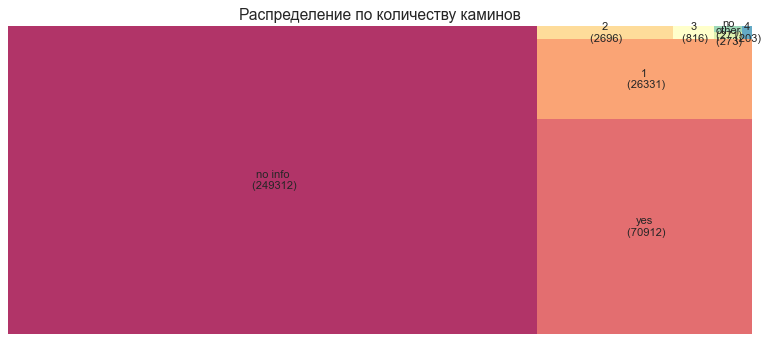

In [71]:
creat_treemap(data, 'fireplace', 'Распределение по количеству каминов', size=[12, 5])

### Обработка признака $'beds'$

In [72]:
# посмотрим на данные
data.beds.value_counts(dropna=False)

NaN            62613
3 Beds         52579
4 Beds         35115
3              31913
2 Beds         25668
               ...  
7,841 sqft         1
8,023 sqft         1
10,193 sqft        1
8.93 acres         1
8,479 sqft         1
Name: beds, Length: 1181, dtype: int64

In [73]:
data.beds = data.beds.apply(lambda x: str(x)) # переводим все значения в строковые
data.beds = data.beds.apply(lambda x: x.lower()) # переводим всё в нижний регистр
data.beds = data.beds.apply(lambda x: str(x).replace(',','.')) # меняем запятые на точки
data.beds = data.beds.apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы

In [74]:
# проверим данные, где вместо количества указана площадь
df_beds_sqft = data.beds.copy()
beds_sqft = []
for item in df_beds_sqft:
    if item.split(' ')[-1] == 'sqft':
        try:
            beds_sqft.append(float(item.split(' ')[0]))
        except ValueError:
            pass
np.median(beds_sqft)

6.359

Получается в среднем площадь спальни 6,4 квадратный фута, что меньше одного квадратного метра, а значит, невозможно. Избавимся от этих данных.

In [75]:
data.beds = data.beds.apply(lambda x: str(x).replace(' beds','')) # убираем лишний текст
data.beds = data.beds.apply(lambda x: str(x).replace('.0','')) # убираем лишний текст
data.beds = data.beds.apply(lambda x: 'no info' if (x.isdigit() == False) or (x == '0') or (x == np.nan) else x) # отмечаем все записи без данных
data.beds = data.beds.apply(lambda x: x if (x == 'no info') or (x == '1') or (x == '2') or (x == '3') or (x == '4') or (x == '5') or (x == '6') else '>6') # группируем экстремумы

In [76]:
# смотрим результат
data.beds.value_counts(dropna=False)

no info    117372
3           93030
4           61434
2           44582
5           19322
6            5879
1            5082
>6           4113
Name: beds, dtype: int64

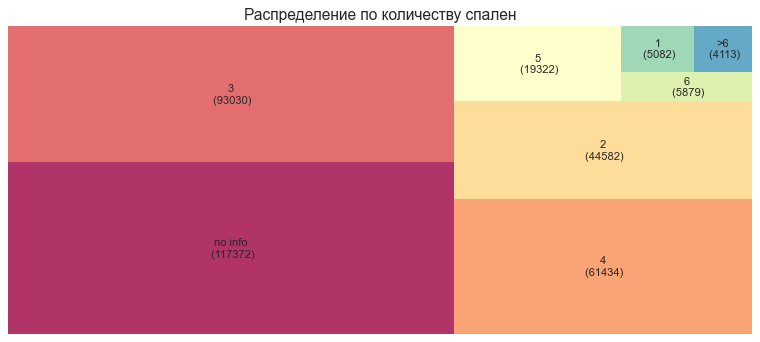

In [77]:
creat_treemap(data, 'beds', 'Распределение по количеству спален', size=[12, 5])

### Обработка признаков $'mls-id'$ и $'MlsId'$

In [78]:
data.MlsId.value_counts()

NO MLS                        23
No MLS #                      16
 A, Houston, TX 77008         13
 12A, Orlando, FL 32833       11
 1, South Boston, MA 02127     9
                              ..
CV19264682                     1
688707                         1
A10779865                      1
68033742                       1
10374233                       1
Name: MlsId, Length: 208393, dtype: int64

In [79]:
data['mls-id'].value_counts()

2152042      3
No MLS#      3
No           3
PA1203991    2
3564688      2
            ..
5113854      1
19-208756    1
19-4797      1
957305       1
F10202858    1
Name: mls-id, Length: 24875, dtype: int64

In [80]:
# удалим данные столбцы, т.к. это ID
data = data.drop(['mls-id', 'MlsId'], axis=1)

### Обработка признака $'stories'$

In [81]:
data.stories = data.stories.apply(lambda x: str(x)) # переводим все значения в строковые
data.stories = data.stories.apply(lambda x: x.lower()) # переводим всё в нижний регистр
data.stories = data.stories.apply(lambda x: str(x).replace(',','')) # убираем запятые
data.stories = data.stories.apply(lambda x: str(x).replace('+',' ')) # заменим лишние символы
data.stories = data.stories.apply(lambda x: str(x).replace('/',' ')) # заменим лишние символы
data.stories = data.stories.apply(lambda x: str(x).replace('.','')) # убираем точки
data.stories = data.stories.apply(lambda x: str(x).replace('0','')) # убираем нули
data.stories = data.stories.apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы

In [82]:
# меняем на числа ошибочные символы
data.stories = data.stories.apply(lambda x: str(x).replace('!','1'))
data.stories = data.stories.apply(lambda x: str(x).replace('@','2'))
data.stories = data.stories.apply(lambda x: str(x).replace('#','3'))
data.stories = data.stories.apply(lambda x: str(x).replace('$','4'))
data.stories = data.stories.apply(lambda x: str(x).replace('%','5'))
data.stories = data.stories.apply(lambda x: str(x).replace('^','6'))
data.stories = data.stories.apply(lambda x: str(x).replace('&','7'))
data.stories = data.stories.apply(lambda x: str(x).replace('*','8'))

In [83]:
def get_stories(row):
    
    # список возможного количества этажей
    nums = ['1','2','3','4','5','6','7','8','9','one','two','three','four','five','six','seven','eight','nine']
    
    # если указано количество этажей, сразу вернем его
    split_str = row.split(' ')
    for num in nums:
        if num in split_str:
            return num
    
    # обработаем возвращение стандартных значений
    if (row is np.nan) or (row == 'nan'):
        return 'no info' # сразу избавляемся от пропусков
    
    return 'other' # сложные описания отметим как "прочие"

In [84]:
# вызываем функцию
data.stories = data.stories.apply(get_stories)

In [85]:
# избавимся от дублирования описания количества каминов
data.stories = data.stories.apply(lambda x: str(x).replace('0','no info'))
data.stories = data.stories.apply(lambda x: str(x).replace('one','1'))
data.stories = data.stories.apply(lambda x: str(x).replace('two','2'))
data.stories = data.stories.apply(lambda x: str(x).replace('three','3'))
data.stories = data.stories.apply(lambda x: str(x).replace('four','4'))
data.stories = data.stories.apply(lambda x: str(x).replace('five','5'))
data.stories = data.stories.apply(lambda x: str(x).replace('six','6'))
data.stories = data.stories.apply(lambda x: str(x).replace('seven','7'))
data.stories = data.stories.apply(lambda x: str(x).replace('eight','8'))
data.stories = data.stories.apply(lambda x: str(x).replace('nine','9'))

In [86]:
# посмотрим на результат
data.stories.value_counts(dropna=False)

no info    123109
1          100736
2           83036
3           17893
other       16907
9            3391
4            3159
6            1019
5             812
7             415
8             337
Name: stories, dtype: int64

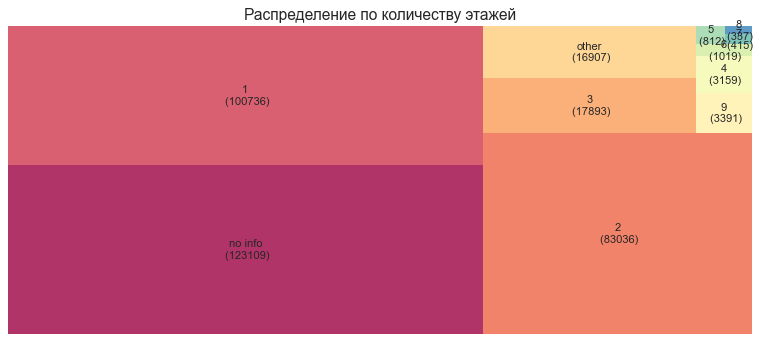

In [87]:
creat_treemap(data, 'stories', 'Распределение по количеству этажей', size=[12, 5])

### Обработка признака $'Year\_built'$

In [88]:
data['Year built'].value_counts(dropna=False)

        32530
2019    32428
2006     8020
2005     7523
2007     7130
        ...  
1780        1
1809        1
1823        1
1807        1
1804        1
Name: Year built, Length: 229, dtype: int64

In [89]:
# проверим пропуски
data['Year built'].isnull().sum()

3582

In [90]:
# проверим распределение данных
years=[]
for year in data['Year built']:
    if (year is not np.nan) and (year != '') and (isinstance(year, str)):
        if (len(year)==4):
            years.append(int(year))
print('Минимальное значение:', np.min(years))
print('Максимальное значение:', np.max(years))
print('Медианное значение:', np.median(years))

Минимальное значение: 1019
Максимальное значение: 2025
Медианное значение: 1985.0


In [91]:
# функция группировки года постройки
def get_year_built(year):
    
    if (year == '') or ((isinstance(year, str)) and (len(year)!=4)):
        return 'no info'
    if (year == np.nan) or (not isinstance(year, str)):
        return 'no info'
    if (isinstance(year, str)) and (len(year)==4):
        year = int(year)
        if year > 2023:
            return 'under construction'
        elif year == 2023:
            return 'new'
        elif year > 2019:
            return '1-3 years'
        elif year > 2009:
            return '4-13 years'
        elif year > 1999:
            return '14-23 years'
        elif year > 1989:
            return '24-33 years'
        elif year > 1979:
            return '34-43 years'
        elif year > 1969:
            return '44-53 years'
        elif year <= 1969:
            return 'old'
        
    return year

In [92]:
# вызовем функцию
data['Year built'] = data['Year built'].apply(get_year_built)

In [93]:
# посмотрим результат
data['Year built'].value_counts(dropna=False)

old                   109622
4-13 years             63684
14-23 years            52240
no info                37336
44-53 years            29551
34-43 years            29390
24-33 years            26374
1-3 years               2615
under construction         2
Name: Year built, dtype: int64

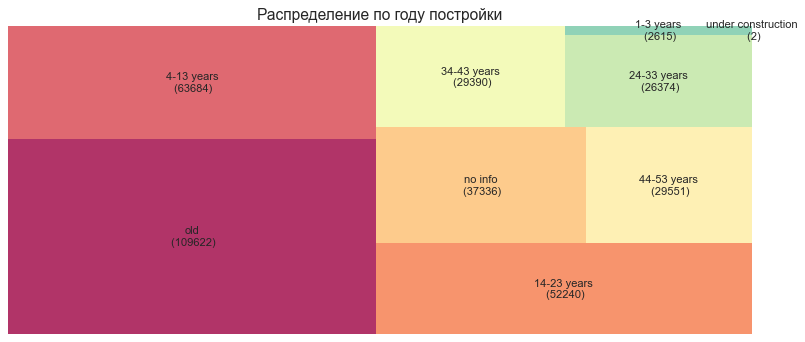

In [94]:
creat_treemap(data, 'Year built', 'Распределение по году постройки', size=[12, 5])

### Обработка признака $'Remodeled\_year'$

In [95]:
data['Remodeled year'].value_counts(dropna=False)

        173795
None     26496
2006      5539
2005      4817
2007      4397
         ...  
1870         1
1853         1
1888         1
1738         1
1862         1
Name: Remodeled year, Length: 152, dtype: int64

In [96]:
# проверим пропуски
data['Remodeled year'].isnull().sum()

26496

In [97]:
# проверим распределение данных
remodeled_years=[]
for year in data['Remodeled year']:
    if (year is not np.nan) and (year != '') and (isinstance(year, str)):
        if (len(year)==4):
            remodeled_years.append(int(year))
print('Минимальное значение:', np.min(remodeled_years))
print('Максимальное значение:', np.max(remodeled_years))
print('Медианное значение:', np.median(remodeled_years))

Минимальное значение: 1738
Максимальное значение: 2021
Медианное значение: 1986.0


In [98]:
# функция группировки года постройки
def get_remodeled_year(year):
    
    if (year == '') or ((isinstance(year, str)) and (len(year)!=4)):
        return 'no info'
    if (year == np.nan) or (not isinstance(year, str)):
        return 'no info'
    if (isinstance(year, str)) and (len(year)==4):
        year = int(year)
        if year > 2019:
            return '1-3 years'
        elif year > 2009:
            return '4-13 years'
        elif year > 1999:
            return '14-23 years'
        elif year > 1989:
            return '24-33 years'
        elif year > 1979:
            return '34-43 years'
        elif year > 1969:
            return '44-53 years'
        elif year <= 1969:
            return 'long time ago'
        
    return year

In [99]:
# вызовем функцию
data['Remodeled year'] = data['Remodeled year'].apply(get_remodeled_year)

In [100]:
# посмотрим результат
data['Remodeled year'].value_counts(dropna=False)

no info          200527
long time ago     39234
14-23 years       34602
34-43 years       22320
44-53 years       19693
24-33 years       19238
4-13 years        15146
1-3 years            54
Name: Remodeled year, dtype: int64

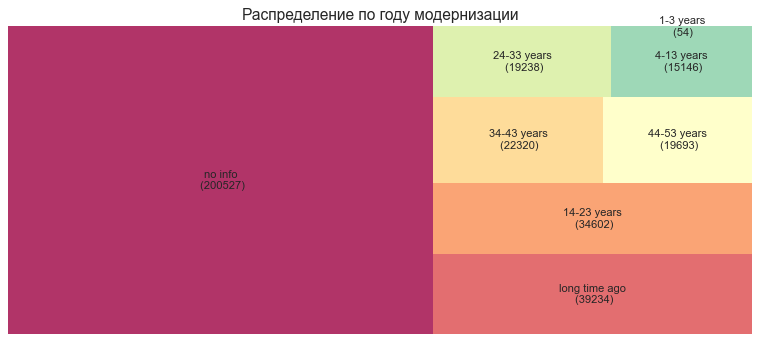

In [101]:
creat_treemap(data, 'Remodeled year', 'Распределение по году модернизации', size=[12, 5])

### Обработка признака $'Heating'$

In [102]:
# проверим пропуски
data.Heating.isnull().sum()

3533

In [103]:
data.Heating = data.Heating.apply(lambda x: str(x)) # переводим все значения в строковые
data.Heating = data.Heating.apply(lambda x: x.lower()) # переводим всё в нижний регистр
data.Heating = data.Heating.apply(lambda x: str(x).replace('/',' ')) # заменим лишние символы
data.Heating = data.Heating.apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы

In [104]:
# сгруппируем все пустые данные
data.Heating = data.Heating.apply(lambda x: 'no info' if (x is np.nan) or (x == '') or (x == 'nan') or (x == 'no data') or (x == 'none') else x) 

In [105]:
# функция определения типа обогрева
def get_heating(heating):
    
    if (heating == 'no info'):
        return 'no info'
    if ('air' in heating):
        return 'forced air'
    elif ('gas' in heating):
        return 'gas'
    elif ('elect' in heating):
        return 'electric'
    elif ('oil' in heating):
        return 'oil'
    else:
        return 'other'

In [106]:
# вызовем функцию
data.Heating = data.Heating.apply(get_heating)

In [107]:
# посмотрим результат
data.Heating.value_counts(dropna=False)

forced air    154207
no info        94599
other          62822
electric       25723
gas            13167
oil              296
Name: Heating, dtype: int64

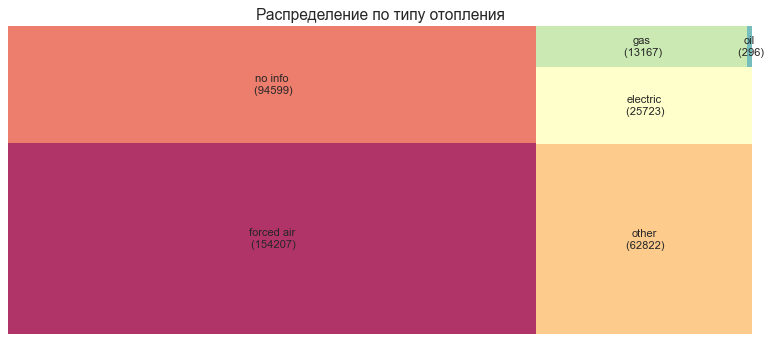

In [108]:
creat_treemap(data, 'Heating', 'Распределение по типу отопления', size=[12, 5])

### Обработка признака $'Cooling'$

In [109]:
# проверим пропуски
data.Cooling.isnull().sum()

3533

In [110]:
data.Cooling = data.Cooling.apply(lambda x: str(x)) # переводим все значения в строковые
data.Cooling = data.Cooling.apply(lambda x: x.lower()) # переводим всё в нижний регистр
data.Cooling = data.Cooling.apply(lambda x: str(x).replace('/',' ')) # заменим лишние символы
data.Cooling = data.Cooling.apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы

In [111]:
# сгруппируем все пустые данные
data.Cooling = data.Cooling.apply(lambda x: 'no info' if (x is np.nan) or (x == '') or (x == 'nan') or (x == 'no data') or (x == 'none') else x) 

In [112]:
# функция определения типа охлаждения
def get_cooling(cooling):
    
    if (cooling == 'no info'):
        return 'no info'
    if ('centr' in cooling):
        return 'central'
    else:
        return 'other'

In [113]:
# вызовем функцию
data.Cooling = data.Cooling.apply(get_cooling)

In [114]:
# посмотрим результат
data.Cooling.value_counts(dropna=False)

central    205720
no info    113021
other       32073
Name: Cooling, dtype: int64

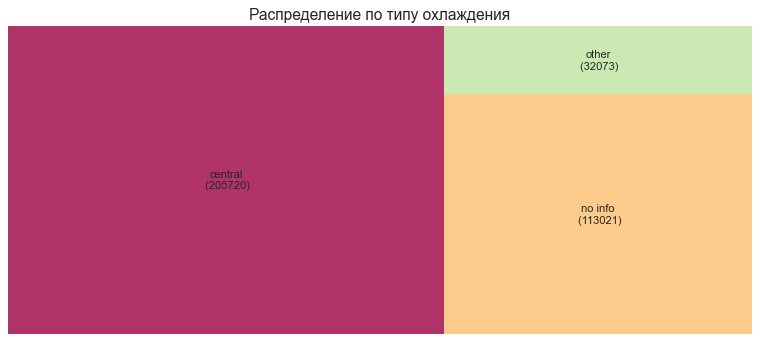

In [115]:
creat_treemap(data, 'Cooling', 'Распределение по типу охлаждения', size=[12, 5])

### Обработка признака $'Parking'$

In [116]:
data.Parking = data.Parking.apply(lambda x: str(x)) # переводим все значения в строковые
data.Parking = data.Parking.apply(lambda x: x.lower()) # переводим всё в нижний регистр
data.Parking = data.Parking.apply(lambda x: str(x).replace('/',' ')) # заменим лишние символы
data.Parking = data.Parking.apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы

In [117]:
# функция определения типа парковки
def get_parking(parking):
    
    if (parking is np.nan) or (parking == '') or (parking == 'nan') or (parking == 'no data') or (parking == 'none') or (parking == '0'):
        return 'no info'
    if ('attach' in parking):
        return 'attached garage'
    elif ('detach' in parking):
        return 'detached garage'
    elif ('carport' in parking):
        return 'carport'
    elif ('street' in parking):
        return 'off street'
    else:
        return 'other'

In [118]:
# вызовем функцию
data.Parking = data.Parking.apply(get_parking)

In [119]:
# посмотрим результат
data.Parking.value_counts(dropna=False)

no info            164741
attached garage     82054
other               71579
detached garage     14890
off street           8958
carport              8592
Name: Parking, dtype: int64

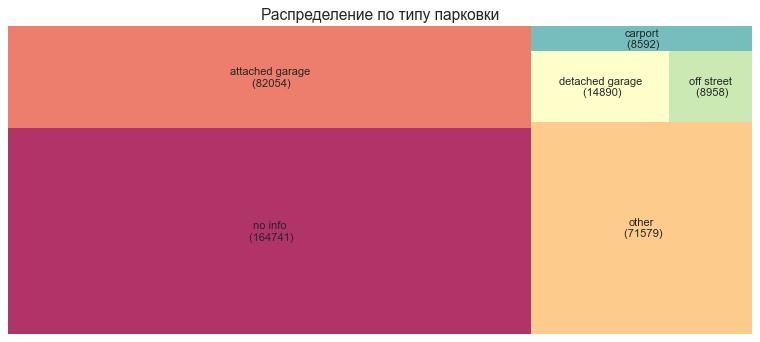

In [120]:
creat_treemap(data, 'Parking', 'Распределение по типу парковки', size=[12, 5])

### Обработка признаков $'schools\_mean\_rate'$, $'schools\_median\_dist'$ и $'schools\_allow\_education'$

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350814 entries, 0 to 350813
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   status                   350814 non-null  object 
 1   propertyType             350814 non-null  object 
 2   baths                    350814 non-null  object 
 3   fireplace                350814 non-null  object 
 4   city                     350814 non-null  object 
 5   sqft                     326428 non-null  object 
 6   beds                     350814 non-null  object 
 7   stories                  350814 non-null  object 
 8   PrivatePool              350814 non-null  int64  
 9   target                   348453 non-null  float64
 10  street_type              350814 non-null  object 
 11  Year built               350814 non-null  object 
 12  Remodeled year           350814 non-null  object 
 13  Heating                  350814 non-null  object 
 14  Cool

In [122]:
# заполним пропуски в свойстве schools_mean_rate
data.schools_mean_rate = data.schools_mean_rate.fillna(data.schools_mean_rate.median())

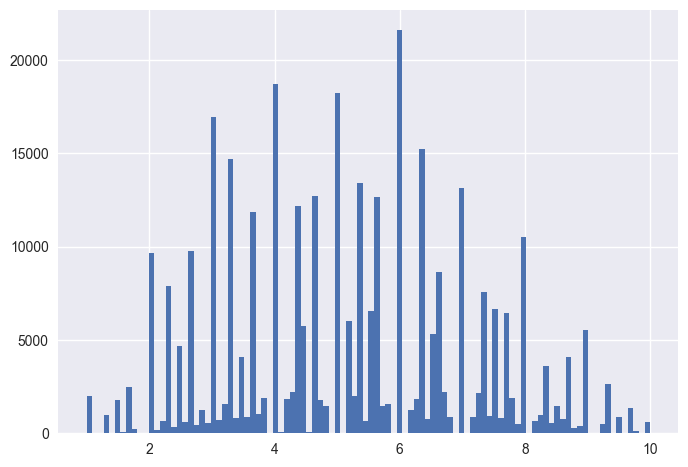

In [123]:
# посмотрим на распределение
data.schools_mean_rate.hist(bins=100);

In [124]:
# заполним пропуски в свойстве schools_median_dist
data.schools_median_dist = data.schools_median_dist.fillna(data.schools_median_dist.median())

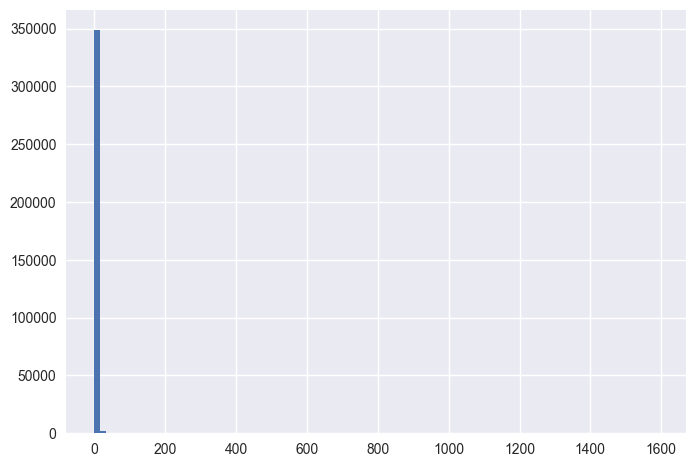

In [125]:
# посмотрим на распределение
data.schools_median_dist.hist(bins=100);

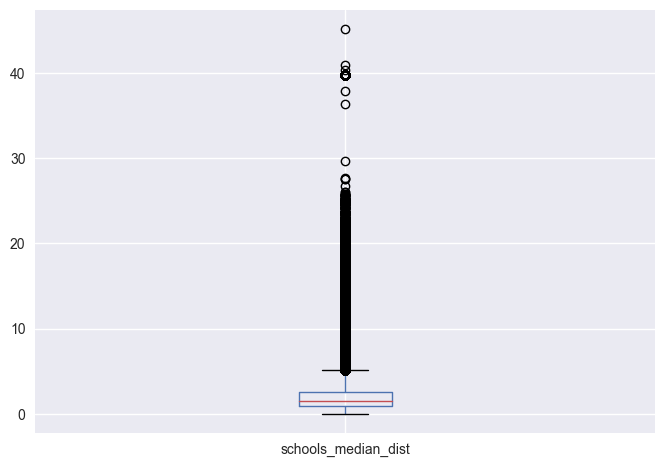

In [126]:
boxplot = data[data['schools_median_dist'] < 100].boxplot(column=['schools_median_dist'])

Возможно, есть выбросы, но удалять не будем, скорее всего признак не сильно влияет на стоимость.

In [127]:
# заполним пропуски в свойстве schools_allow_education
data.schools_allow_education = data.schools_allow_education.fillna(data.schools_allow_education.mode()[0])

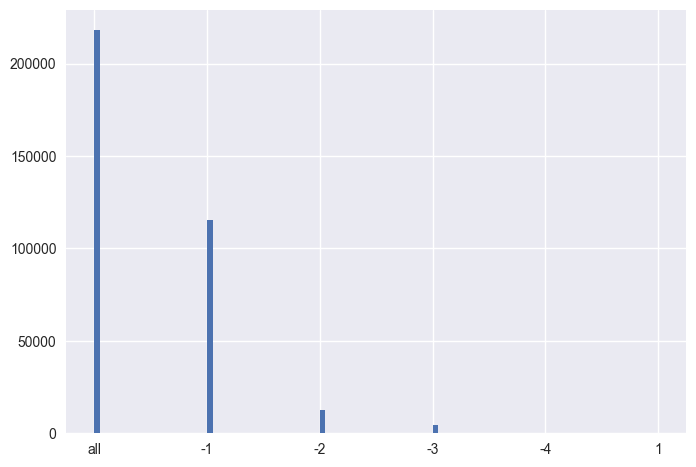

In [128]:
# посмотрим на распределение
data.schools_allow_education.hist(bins=100);

### Обработка признаков $'sqft'$ и $'lotsize'$

In [129]:
data.sqft.value_counts(dropna=False).head(50)

NaN           24386
0              1025
1,200 sqft      815
1,000 sqft      635
1,100 sqft      560
1,800 sqft      555
--              533
1,500 sqft      533
2,000 sqft      509
1,400 sqft      508
1,600 sqft      449
800 sqft        438
1,300 sqft      403
900 sqft        392
1,440 sqft      372
2,400 sqft      365
2,200 sqft      353
1,200           347
960 sqft        334
3,000 sqft      333
2,100 sqft      318
1,500           302
1,700 sqft      301
1,152 sqft      299
1,120 sqft      292
1,344 sqft      289
1,250 sqft      288
-- sqft         288
960             287
750 sqft        279
2,500 sqft      275
850 sqft        268
1,056 sqft      266
1,320 sqft      255
1,080 sqft      253
1,248 sqft      248
950 sqft        247
700 sqft        247
1,900 sqft      240
1,050 sqft      239
1,350 sqft      237
800             237
2,300 sqft      236
1,296 sqft      236
1,800           234
1,100           230
1,650 sqft      225
1,600           222
1,260 sqft      221
1,400           221


In [130]:
data.sqft = data.sqft.apply(lambda x: str(x)) # переводим все значения в строковые
data.sqft = data.sqft.apply(lambda x: x.lower()) # переводим всё в нижний регистр
data.sqft = data.sqft.apply(lambda x: str(x).replace(',','')) # заменим лишние символы
data.sqft = data.sqft.apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы

In [131]:
# функция определения типа парковки
def get_sqft(sqft):
    
    sqft = str(sqft).replace('sqft', '') # удаляем лишнюю информацию
    sqft = str(sqft).replace('total interior livable area: ', '') # удаляем лишнюю информацию
    sqft = str(sqft).replace(' ', '') # удаляем лишнюю информацию
    
    if ('--' in sqft) or (sqft == '0') or (sqft == 'nan'):
        return np.nan
    try:
        sqft = float(sqft)
        return sqft
    except:
        return np.nan
    return sqft

In [132]:
# вызовем функцию
data.sqft = data.sqft.apply(get_sqft)

In [133]:
data.sqft.describe()

count    3.245820e+05
mean     8.005844e+03
std      1.799114e+06
min      1.000000e+00
25%      1.301000e+03
50%      1.844000e+03
75%      2.624000e+03
max      7.959794e+08
Name: sqft, dtype: float64

In [134]:
data.sqft.isnull().sum()

26232

In [135]:
# посмотрим на объекты больше 100 тыс квадратных футов
data[data['sqft'] > 1e+05]

,status,propertyType,baths,fireplace,city,sqft,beds,stories,PrivatePool,target,...,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,schools_count,schools_mean_rate,schools_median_dist,schools_allow_education
85,sale,condo,2.0,no info,other,107250.0,2,no info,0,319000.0,...,no info,no info,no info,no info,0.75 acres,None,3,5.333333,0.68,-1
131,sale,small_house,2.0,no info,other,109200.0,no info,no info,0,270000.0,...,no info,other,no info,no info,0.92 acres,None,3,8.000000,0.58,-1
194,sale,condo,2.0,no info,million,225667.0,no info,other,0,455000.0,...,no info,no info,no info,no info,0.62 acres,$2/sqft,3,1.666667,0.84,-1
303,sale,condo,2.0,no info,other,373772.0,no info,1,0,239000.0,...,no info,other,no info,attached garage,6.04 acres,$1/sqft,3,7.666667,0.53,-2
550,sale,condo,4.0,yes,million,142075.0,4,other,0,5300000.0,...,no info,no info,central,no info,0.27 acres,$37/sqft,7,8.142857,3.36,all
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348844,sale,condo,2.0,no info,other,328560.0,no info,1,1,425000.0,...,no info,other,central,attached garage,5.76 acres,None,3,7.666667,1.17,-2
349043,sale,condo,2.0,no info,other,444115.0,2,1,0,475000.0,...,no info,no info,no info,no info,4.78 acres,$1/sqft,6,5.000000,0.52,all
350210,sale,other,2.0,no info,low_middle,456602479.0,no info,no info,0,198000.0,...,no info,electric,central,no info,456509,No Info,5,6.333333,4.90,all
350211,sale,other,2.0,no info,low_middle,456602479.0,no info,no info,0,198000.0,...,no info,electric,central,no info,456509,No Info,5,6.333333,4.90,all


Точно есть выбросы, попробуем точнее их идентифицировать с помощью второго признака $'lotsize'$. Кроме того отдельно надо проанализировать площадь земельных участков, возможно, данные в признаке $'sqft'$ представлены в акрах.

In [136]:
data.lotsize.value_counts(dropna=False).head(50)

                  32141
None              28897
—                 25180
No Data            5355
-- sqft lot        3932
0.26 acres         2199
0.28 acres         1866
0.25 acres         1831
0.27 acres         1749
0.29 acres         1662
6,098 sqft         1531
0.34 acres         1422
7,405 sqft         1359
0.3 acres          1358
6,534 sqft         1299
4,356 sqft         1260
0.31 acres         1187
5,227 sqft         1161
10,000 sqft        1149
0.32 acres         1119
5,000 sqft         1096
8,712 sqft         1013
8,276 sqft          985
0.33 acres          983
3,920 sqft          982
0.35 acres          967
0.36 acres          860
0.37 acres          823
0.46 acres          820
9,583 sqft          743
4,792 sqft          742
0.4 acres           727
4,791 sqft          722
0.38 acres          710
1 acre              694
0.39 acres          680
7,840 sqft          662
10,454 sqft         661
6,969 sqft          657
2,500 sqft          653
0.26 Acres          638
0.41 acres      

In [137]:
data.lotsize = data.lotsize.apply(lambda x: str(x)) # переводим все значения в строковые
data.lotsize = data.lotsize.apply(lambda x: x.lower()) # переводим всё в нижний регистр
data.lotsize = data.lotsize.apply(lambda x: str(x).replace(',','')) # заменим лишние символы
data.lotsize = data.lotsize.apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы

In [138]:
# функция определения типа парковки
def get_lotsize(sqft):
    
    sqft = str(sqft).replace('sqft', '') # удаляем лишнюю информацию
    sqft = str(sqft).replace('sq. ft.', '') # удаляем лишнюю информацию
    sqft = str(sqft).replace('lot', '') # удаляем лишнюю информацию
    sqft = str(sqft).replace(' ', '') # удаляем лишнюю информацию
    
    if ('--' in sqft) or ('—' in sqft) or (sqft == '0') or (sqft == 'none') or (sqft == 'nodata') or (sqft == 'nan'):
        return np.nan
    if 'acr' in str(sqft):
        sqft = str(sqft)[0:str(sqft).find('a')]
        try:
            sqft = float(sqft) * 43560 # переводим акры в квадратные футы
            return sqft
        except:
            return np.nan
    try:
        sqft = float(sqft)
        if sqft < 0:
            return np.nan 
        return sqft
    except:
        return np.nan
    return sqft

In [139]:
# вызовем функцию
data.lotsize = data.lotsize.apply(get_lotsize)

In [140]:
data.lotsize.describe()

count    2.553070e+05
mean     9.491019e+04
std      6.328594e+06
min      1.000000e+00
25%      5.009000e+03
50%      7.823000e+03
75%      1.263240e+04
max      2.147484e+09
Name: lotsize, dtype: float64

In [141]:
data.loc[data[data.lotsize < 200].index, 'lotsize'] = np.nan

In [142]:
# слишком маленькие значения sqft, сотрем, чтобы преобразовать в медианное
data.loc[data[data.sqft < 200].index, 'sqft'] = np.nan

In [143]:
# построим вспомогательную таблицу со средними ценами за квадратный фут по типам объектов
df_test = data[['propertyType','sqft','target']].copy()
df_test.loc[df_test[df_test.target < 1000].index, 'target'] = np.nan
df_test = df_test.dropna(axis='index', how='any', subset=['sqft','target'])
df_test['price/sqft'] = df_test['target'] / df_test['sqft']
df_test = df_test.drop(['sqft','target'], axis=1)
df_price_property = df_test.groupby(by = 'propertyType').median()
df_price_property

,price/sqft
propertyType,
condo,314.343249
cottage,240.975211
farmhouse,247.551687
log_house,179.004854
other,179.157584
small_house,157.665610
townhouse,186.421755


In [144]:
# избавимся от пропусков по максимум реальными данными из lotsize, а потом просто медианным значением
data.sqft = data.sqft.fillna(data.lotsize)

In [145]:
data.sqft.describe()

count    3.361680e+05
mean     1.645359e+04
std      2.089150e+06
min      2.000000e+02
25%      1.320000e+03
50%      1.884000e+03
75%      2.738000e+03
max      7.959794e+08
Name: sqft, dtype: float64

In [146]:
data.sqft = data.sqft.fillna(0)
for row in range(data.shape[0]):
    if (data.loc[row, 'sqft'] == 0):
        if (data.loc[row, 'target'] is not np.nan):
            data.loc[row, 'sqft'] = data.loc[row, 'target'] / df_price_property.loc[data.loc[row, 'propertyType'], 'price/sqft']

In [147]:
data.loc[data[data.sqft < 200].index, 'sqft'] = np.nan

In [148]:
# проверим итоговое число пропусков
data.sqft.isnull().sum()

1246

Попробуем еще раз после окончательной обработки признака $'target'$

In [149]:
data.sqft.describe()

count    3.495680e+05
mean     1.613637e+04
std      2.048721e+06
min      2.000000e+02
25%      1.316000e+03
50%      1.896000e+03
75%      2.792000e+03
max      7.959794e+08
Name: sqft, dtype: float64

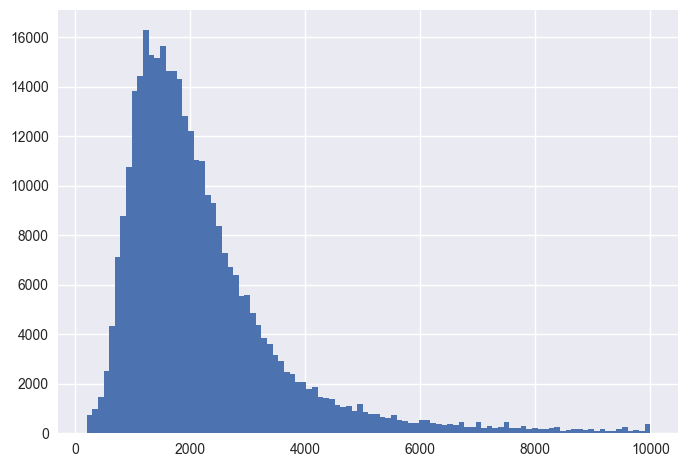

In [150]:
# посмотрим на распределение
data[data.sqft < 1e+04].sqft.hist(bins=100);

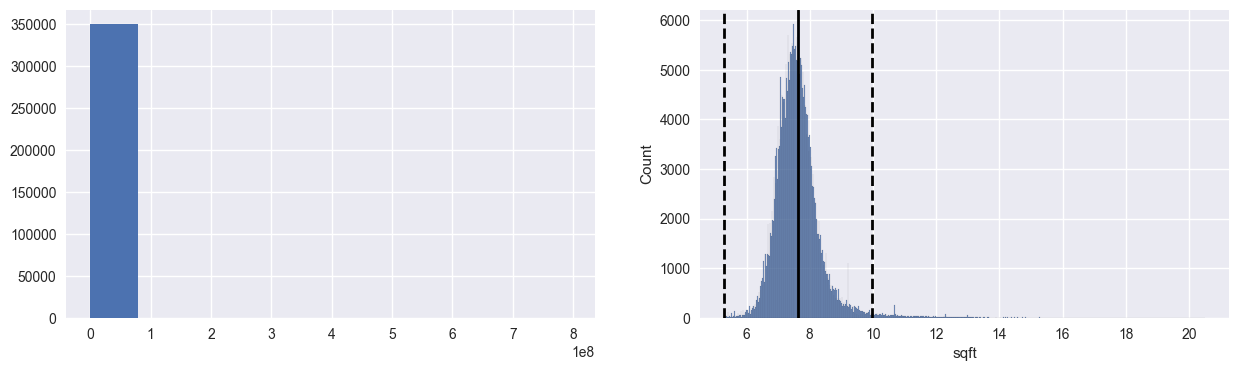

In [151]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
data.sqft.hist(ax=axes[0])
#Логарифмируем
log_sqft = np.log(data['sqft'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_sqft, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_sqft.mean(), color='k', lw=2)
axes[1].axvline(log_sqft.mean()+ 3 *log_sqft.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_sqft.mean()- 3 *log_sqft.std(),
                color='k', ls='--', lw=2);

In [152]:
# удалим лишний столбец (по идее, должны коррелировать, но можно не проверять)
data = data.drop(['lotsize'], axis=1)

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350814 entries, 0 to 350813
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   status                   350814 non-null  object 
 1   propertyType             350814 non-null  object 
 2   baths                    350814 non-null  object 
 3   fireplace                350814 non-null  object 
 4   city                     350814 non-null  object 
 5   sqft                     349568 non-null  float64
 6   beds                     350814 non-null  object 
 7   stories                  350814 non-null  object 
 8   PrivatePool              350814 non-null  int64  
 9   target                   348453 non-null  float64
 10  street_type              350814 non-null  object 
 11  Year built               350814 non-null  object 
 12  Remodeled year           350814 non-null  object 
 13  Heating                  350814 non-null  object 
 14  Cool

### Обработка признаков $'Price/sqft'$ и окончательная обработка целевого признака $'target'$

In [154]:
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x)) # переводим все значения в строковые
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: x.lower()) # переводим всё в нижний регистр
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace(',','')) # заменим лишние символы
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: " ".join(x.split())) # удаляем лишние пробелы
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace('sqft', '')) # удаляем лишнюю информацию
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace('sq. ft.', '')) # удаляем лишнюю информацию
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace('lot', '')) # удаляем лишнюю информацию
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace(' ', '')) # удаляем лишнюю информацию
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace('/', '')) # удаляем лишнюю информацию
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace('$', '')) # удаляем лишнюю информацию
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace('contactmanager', '')) # удаляем лишнюю информацию
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace('--', 'nan')) # приводим к единообразию пустые значения
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace('—', 'nan')) # приводим к единообразию пустые значения
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace('none', 'nan')) # приводим к единообразию пустые значения
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace('nodata', 'nan')) # приводим к единообразию пустые значения
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: str(x).replace('noinfo', 'nan')) # приводим к единообразию пустые значения
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: 'nan' if str(x) == '' else x) # приводим к единообразию пустые значения
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: 'nan' if x == '0' else x) # приводим к единообразию пустые значения

In [155]:
# выполним обратное преобразование пропусков
data['Price/sqft'] = data['Price/sqft'].apply(lambda x: np.nan if x == 'nan' else float(x)) 

In [156]:
data.loc[data[(data.target.isnull()) & (data['Price/sqft'] < 100)].index, 'Price/sqft'] = np.nan

In [157]:
# выполним обратное преобразование пропусков в целевом признаке
data.target = data.target.apply(lambda x: np.nan if x == 'nan' else float(x)) 
# избавимся от пропусков по максимум реальными данными из Price/sqft
data.target = data.target.fillna(data['Price/sqft']*data['sqft'])
# избавимся от оставшихся пропусков
data = data.dropna(axis='index', how='any', subset=['target'])

In [158]:
# сотрем подозрительно маленькие значения
data.target = data.target.apply(lambda x: np.nan if x < 3000 else x)

In [159]:
# удаляем лишний столбец
data = data.drop('Price/sqft', axis=1)

In [160]:
data = data.dropna(axis='index', how='any', subset=['target', 'sqft'])

In [161]:
data.reset_index(drop=True, inplace=True)
data['Price/sqft'] = data.target / data.sqft

In [162]:
data['Price/sqft'].describe()

count    346729.000000
mean        259.215037
std         353.556170
min           0.000035
25%         120.826833
50%         178.062678
75%         285.891325
max       37500.000000
Name: Price/sqft, dtype: float64

Пустые данные о площади удалены вместе с пустыми данными целевого признака

### Работа с выбросами

In [163]:
sqft25 = int(data.sqft.quantile(0.25))
sqft50 = int(data.sqft.quantile(0.50))
sqft75 = int(data.sqft.quantile(0.75))

print('25 квантиль:', sqft25)
print('50 квантиль:', sqft50)
print('75 квантиль:', sqft75)

25 квантиль: 1319
50 квантиль: 1900
75 квантиль: 2796


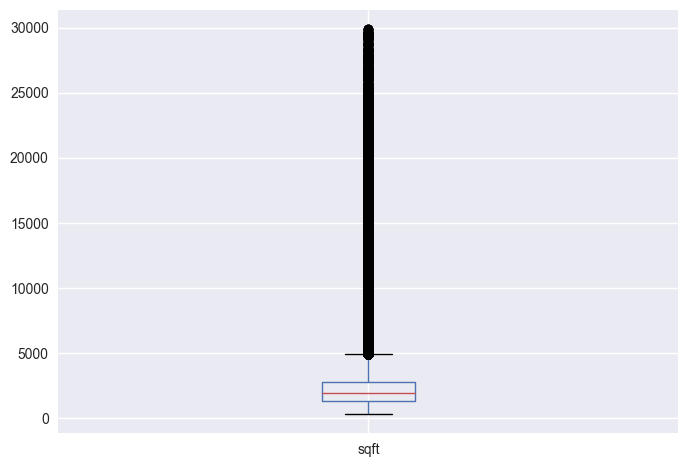

In [164]:
boxplot = data[(data.sqft < 3e4) & (data.sqft > 300)].boxplot(column=['sqft'])

In [165]:
data[(data.sqft >= 5e4) | (data.sqft <= 300)]

,status,propertyType,baths,fireplace,city,sqft,beds,stories,PrivatePool,target,...,Year built,Remodeled year,Heating,Cooling,Parking,schools_count,schools_mean_rate,schools_median_dist,schools_allow_education,Price/sqft
58,sale,other,2.0,no info,low_middle,2.790839e+02,no info,no info,0,50000.0,...,no info,no info,no info,no info,no info,5,4.250000,12.10,-1,179.157584
80,sale,other,2.0,no info,high,1.128204e+05,no info,no info,0,18000.0,...,no info,no info,no info,no info,no info,3,4.333333,7.70,-1,0.159546
84,sale,condo,2.0,no info,other,1.072500e+05,2,no info,0,319000.0,...,old,no info,no info,no info,no info,3,5.333333,0.68,-1,2.974359
128,sale,small_house,2.0,no info,other,1.092000e+05,no info,no info,0,270000.0,...,old,no info,other,no info,no info,3,8.000000,0.58,-1,2.472527
154,sale,other,2.0,no info,other,2.952708e+02,no info,no info,0,52900.0,...,no info,no info,no info,no info,no info,4,6.000000,4.10,-1,179.157584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346068,sale,other,2.0,no info,million,8.372517e+04,no info,no info,0,15000000.0,...,no info,no info,no info,no info,no info,5,8.000000,0.20,-1,179.157584
346134,sale,other,2.0,no info,low_middle,4.566025e+08,no info,no info,0,198000.0,...,4-13 years,no info,electric,central,no info,5,6.333333,4.90,all,0.000434
346135,sale,other,2.0,no info,low_middle,4.566025e+08,no info,no info,0,198000.0,...,4-13 years,no info,electric,central,no info,5,6.333333,4.90,all,0.000434
346320,no info,other,2.0,no info,million,2.093129e+02,no info,no info,0,37500.0,...,no info,no info,no info,no info,no info,3,2.333333,1.10,all,179.157584


In [166]:
data = data[(data.sqft < 5e4) & (data.sqft > 300)]
data.reset_index(drop=True, inplace=True)

In [167]:
data.target.describe()

count    3.431170e+05
mean     6.546233e+05
std      1.663521e+06
min      3.000000e+03
25%      2.120000e+05
50%      3.399000e+05
75%      5.994300e+05
max      1.650000e+08
Name: target, dtype: float64

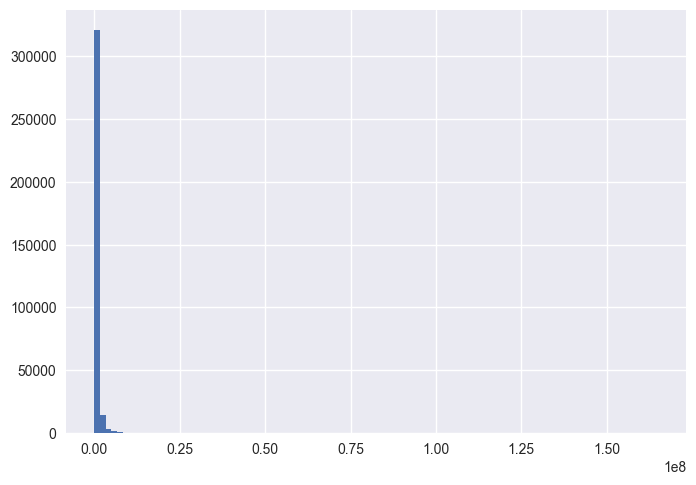

In [168]:
# посмотрим на распределение
data.target.hist(bins=100);

In [169]:
data.target.max(), data.target.mean(), data.target.median(), data.target.min()

(165000000.0, 654623.2871119764, 339900.0, 3000.0)

In [170]:
tar25 = int(data.target.quantile(0.25))
tar50 = int(data.target.quantile(0.50))
tar75 = int(data.target.quantile(0.75))

print('25 квантиль:', tar25)
print('50 квантиль:', tar50)
print('75 квантиль:', tar75)

25 квантиль: 212000
50 квантиль: 339900
75 квантиль: 599430


In [171]:
print('Ниже 25-го квантиля:', len(data[data['target'] < tar25]), 'объектов')
print('Выше 75-го квантиля:', len(data[data['target'] > tar75]), 'объектов')
print('Между 25-ым и 75-ым квантилями:', len(data[(data['target'] >= tar25) & (data['target'] <= tar75)]), 'объектов')

Ниже 25-го квантиля: 85660 объектов
Выше 75-го квантиля: 85779 объектов
Между 25-ым и 75-ым квантилями: 171678 объектов


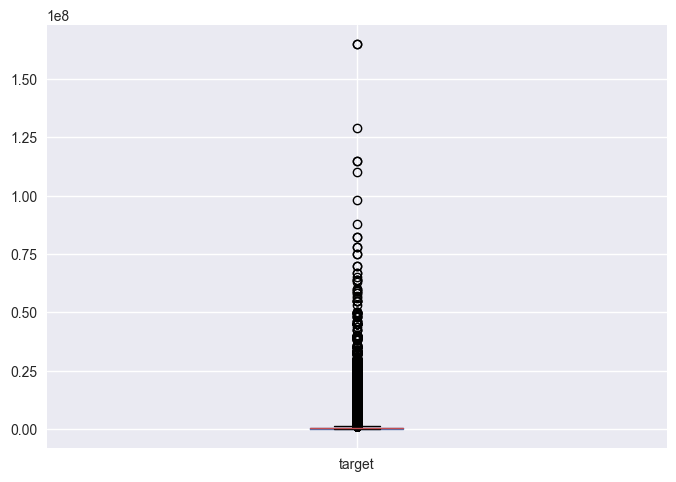

In [172]:
boxplot = data.boxplot(column=['target'])

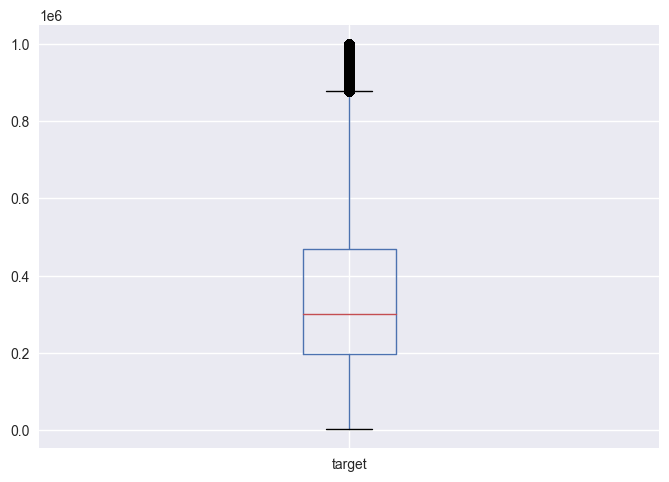

In [173]:
boxplot = data[data.target < 1e6].boxplot(column=['target'])

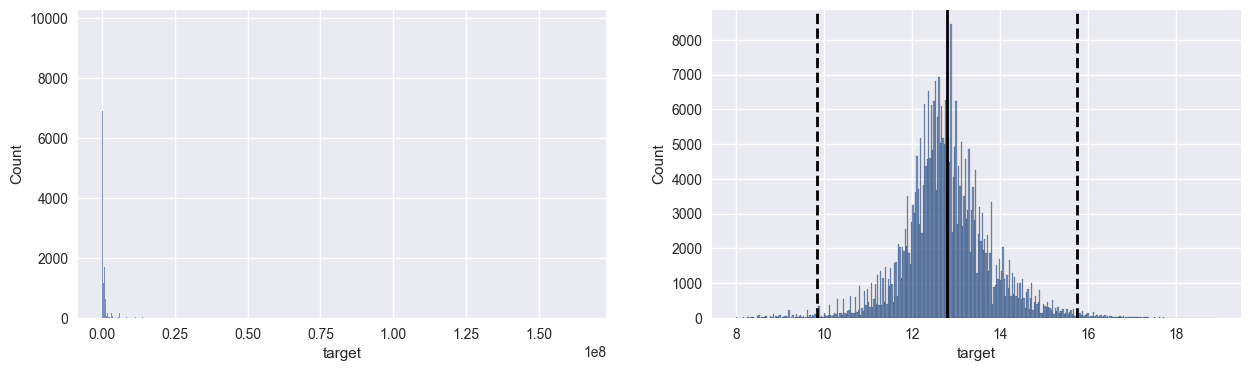

In [174]:
# посмотрим на логарифмированный целевой признак
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=data, x='target', ax=axes[0]);
#Логарифмируем
log_target = np.log(data['target'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_target, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_target.mean(), color='k', lw=2)
axes[1].axvline(log_target.mean()+ 3 *log_target.std(), color='k', ls='--', lw=2)
axes[1].axvline(log_target.mean()- 3 *log_target.std(), color='k', ls='--', lw=2);

In [175]:
# Метод межквартильного размаха (метод Тьюки)
def outliers_iqr(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [176]:
outliers, cleaned = outliers_iqr(data, 'target')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 35785
Результирующее число записей: 307332


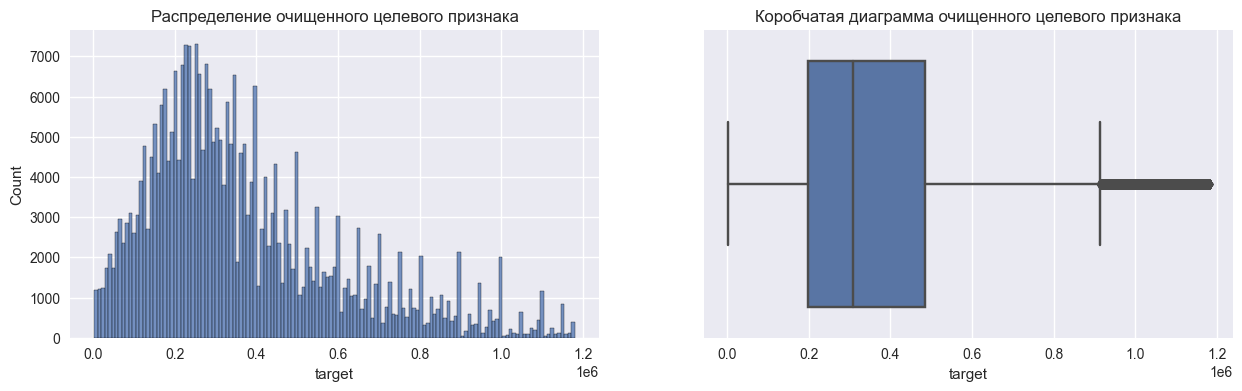

In [177]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='target', ax=axes[0]);
histplot.set_title('Распределение очищенного целевого признака');
boxplot = sns.boxplot(data=cleaned, x='target', ax=axes[1]);
boxplot.set_title('Коробчатая диаграмма очищенного целевого признака');

In [178]:
# Метод Z-отклонений (Метод сигм)
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [179]:
outliers_z, cleaned_z = outliers_z_score(data, 'target', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers_z.shape[0]}')
print(f'Результирующее число записей: {cleaned_z.shape[0]}')

Число выбросов по методу z-отклонения: 4704
Результирующее число записей: 338413


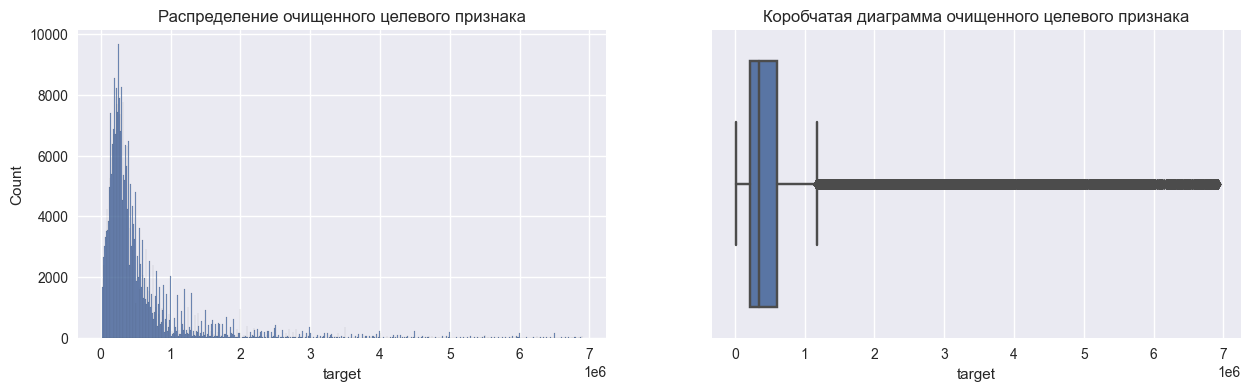

In [180]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned_z, x='target', ax=axes[0]);
histplot.set_title('Распределение очищенного целевого признака');
boxplot = sns.boxplot(data=cleaned_z, x='target', ax=axes[1]);
boxplot.set_title('Коробчатая диаграмма очищенного целевого признака');

Метод Тьюки с параметрами по-умолчанию предлагает к удалению слишком много данных, при этом результат сложно интерпретировать. Остановимся на методе 3 сигм.

In [181]:
# удалим выбросы
data = data.drop(list(outliers_z.index), axis=0)
data.reset_index(drop=True, inplace=True)

In [182]:
data['Price/sqft'].describe()

count    338413.000000
mean        248.331208
std         246.750565
min           0.413223
25%         122.249389
50%         178.502093
75%         284.816754
max       13598.326360
Name: Price/sqft, dtype: float64

In [183]:
outliers_price, cleaned_price = outliers_iqr(data, 'Price/sqft')
print(f'Число выбросов по методу Тьюки: {outliers_price.shape[0]}')
print(f'Результирующее число записей: {cleaned_price.shape[0]}')

Число выбросов по методу Тьюки: 29486
Результирующее число записей: 308927


In [184]:
outliers_price_z, cleaned_price_z = outliers_z_score(data, 'Price/sqft', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers_price_z.shape[0]}')
print(f'Результирующее число записей: {cleaned_price_z.shape[0]}')

Число выбросов по методу z-отклонения: 4873
Результирующее число записей: 333540


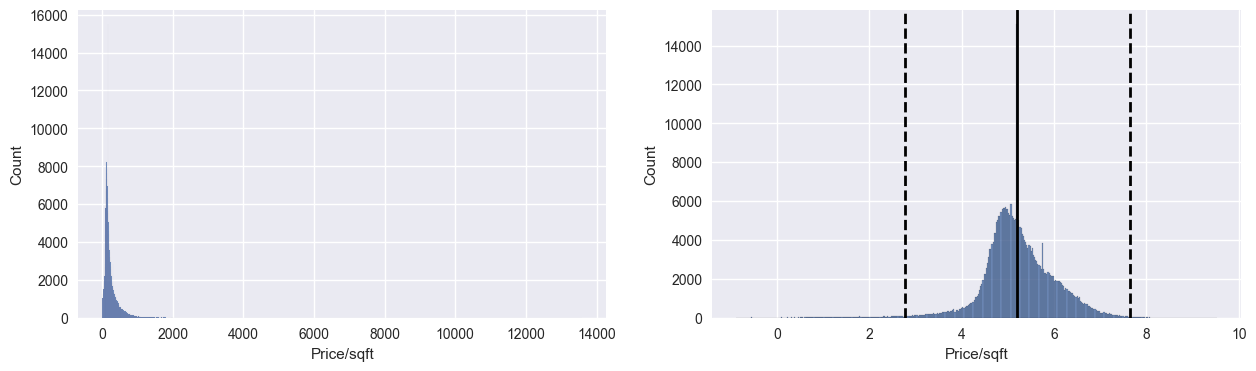

In [185]:
# посмотрим на логарифмированный целевой признак
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=data, x='Price/sqft', ax=axes[0]);
#Логарифмируем
log_target = np.log(data['Price/sqft'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_target, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_target.mean(), color='k', lw=2)
axes[1].axvline(log_target.mean()+ 3 *log_target.std(), color='k', ls='--', lw=2)
axes[1].axvline(log_target.mean()- 3 *log_target.std(), color='k', ls='--', lw=2);

In [186]:
# удалим выбросы
data = data.drop(list(outliers_price_z.index), axis=0)
data.reset_index(drop=True, inplace=True)

In [189]:
data = data.drop(['Price/sqft'], axis=1)

In [190]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333540 entries, 0 to 333539
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   status                   333540 non-null  object 
 1   propertyType             333540 non-null  object 
 2   baths                    333540 non-null  object 
 3   fireplace                333540 non-null  object 
 4   city                     333540 non-null  object 
 5   sqft                     333540 non-null  float64
 6   beds                     333540 non-null  object 
 7   stories                  333540 non-null  object 
 8   PrivatePool              333540 non-null  int64  
 9   target                   333540 non-null  float64
 10  street_type              333540 non-null  object 
 11  Year built               333540 non-null  object 
 12  Remodeled year           333540 non-null  object 
 13  Heating                  333540 non-null  object 
 14  Cool

In [191]:
data.head()

,status,propertyType,baths,fireplace,city,sqft,beds,stories,PrivatePool,target,street_type,Year built,Remodeled year,Heating,Cooling,Parking,schools_count,schools_mean_rate,schools_median_dist,schools_allow_education
0,sale,small_house,4.0,1,other,2900.0,4,no info,0,418000.0,lane,4-13 years,no info,other,no info,no info,8,5.200000,3.80,all
1,sale,small_house,3.0,no info,low,1947.0,3,2,0,310000.0,avenue,4-13 years,no info,no info,no info,no info,3,4.000000,1.32,all
2,sale,small_house,2.0,yes,million,3000.0,3,1,1,2895000.0,road,old,long time ago,forced air,central,attached garage,3,6.666667,2.06,-1
3,sale,small_house,>4,yes,million,6457.0,5,3,0,2395000.0,avenue,14-23 years,14-23 years,forced air,central,detached garage,4,9.250000,0.93,all
4,sale,townhouse,2.0,no info,million,897.0,2,2,0,209000.0,street,old,no info,forced air,central,no info,0,5.166667,1.50,all


In [192]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['sqft',
 'PrivatePool',
 'target',
 'schools_count',
 'schools_mean_rate',
 'schools_median_dist']

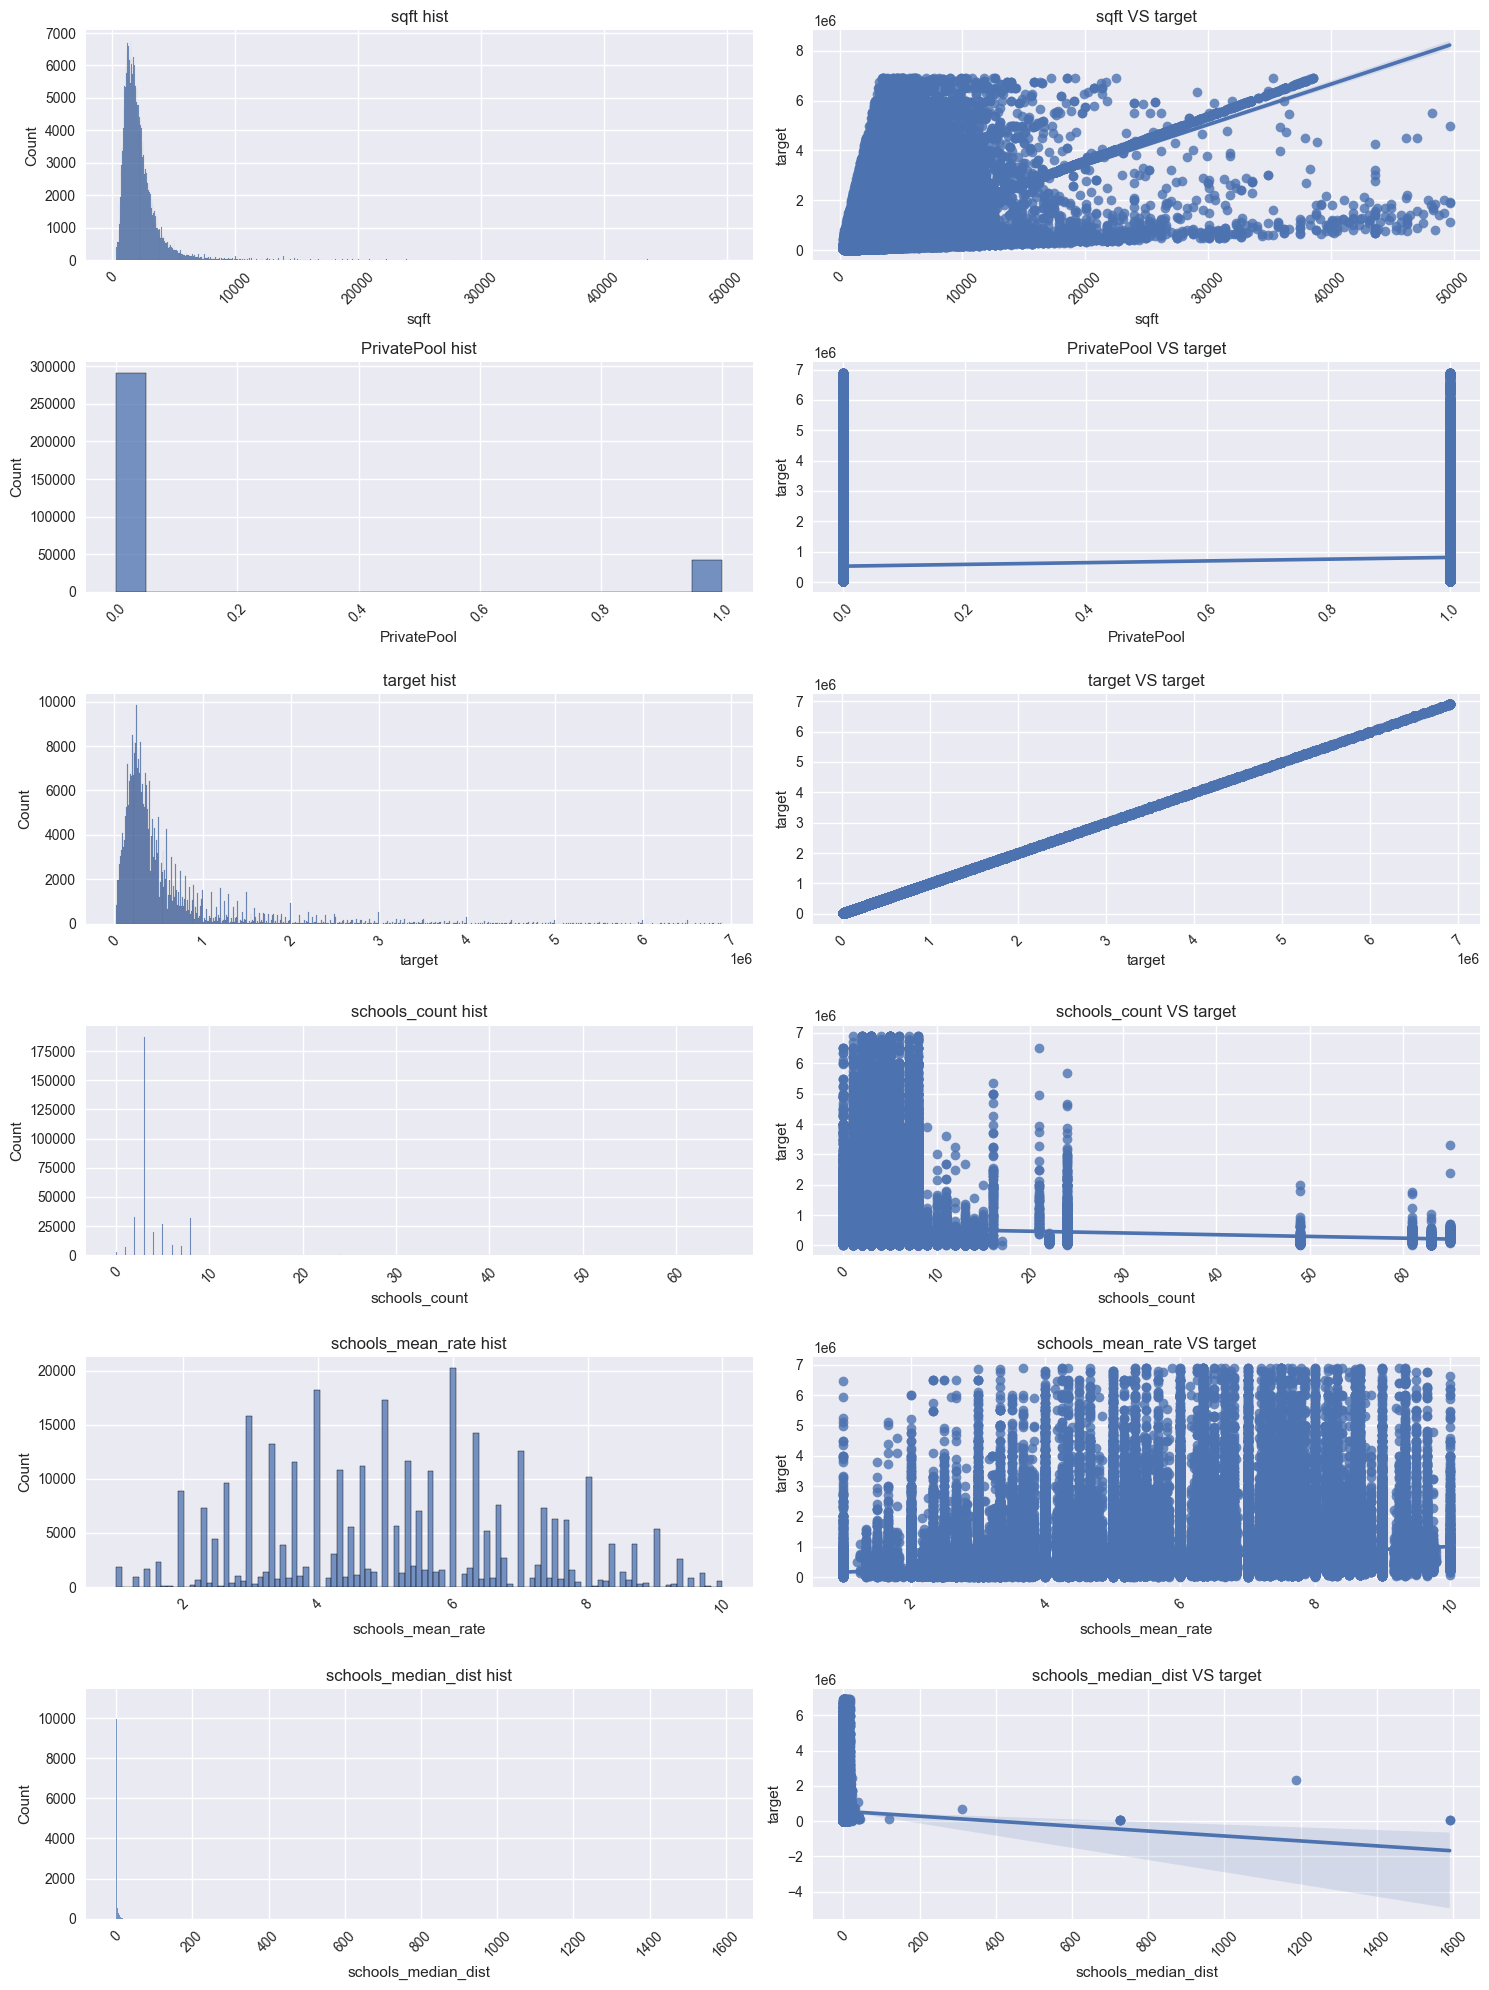

In [193]:
# посмотрим на зависимость целевого признака от каждого числового фактора
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='target', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS target'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

По графикам в глаза бросается вывод: чем больше вокруг школ, тем меньше стоимость жилья. Это неправда, удалим этот фактор.

In [194]:
data = data.drop('schools_count', axis=1)

In [195]:
# также удалим несколько выбросов в средней дальности до школ
data = data[data['schools_median_dist']<100]
data.reset_index(drop=True, inplace=True)

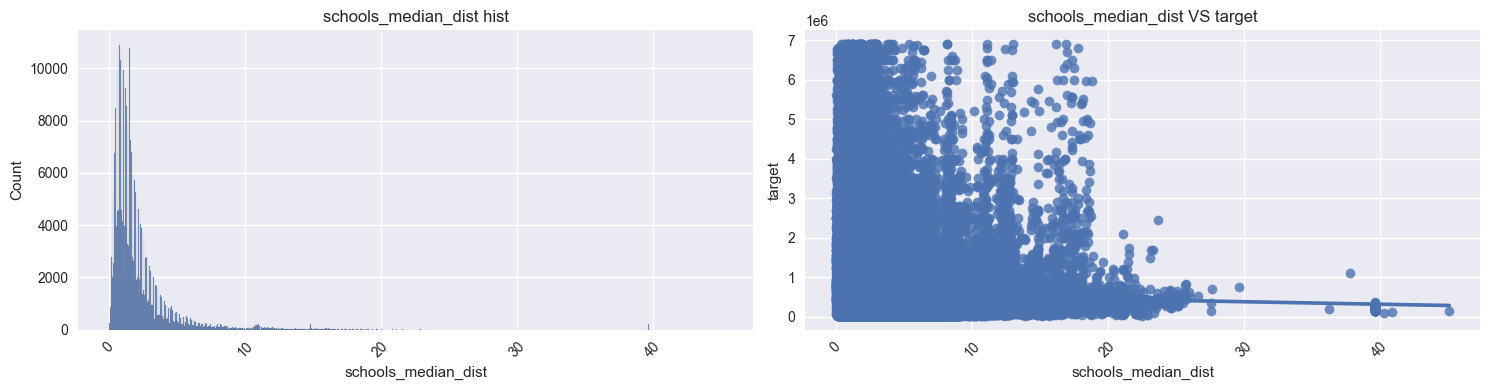

In [196]:
# проверим, как поменялся график
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) # фигура 
#Строим гистограмму распределения признака 
histplot = sns.histplot(data=data, x='schools_median_dist', ax=axes[0])
#Добавляем подпись графику
histplot.set_title('{} hist'.format('schools_median_dist'))
#Добавляем поворот отметок на оси абсцисс
histplot.xaxis.set_tick_params(rotation=45)
#Строим диаграмму рассеяния + линейную регрессию
regplot = sns.regplot(data=data, x='schools_median_dist', y='target', ax=axes[1])
#Добавляем подпись графику
regplot.set_title('{} VS target'.format('schools_median_dist'));
#Добавляем поворот отметок на оси абсцисс
regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

In [197]:
# удалим дубликаты (они особенно вскрываются после обработки данных)
mask = data.duplicated()
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')
data = data.drop_duplicates()
print(f'Результирующее число записей: {data.shape[0]}')

Число найденных дубликатов: 5107
Результирующее число записей: 328423


In [198]:
data.to_csv(r'data_EDA.csv', index=False)